In [ ]:
!pip install sympy==1.12


  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [ ]:
!pip install torch-vggish-yamnet #PyTorch wrapper library that lets you load and use YAMNet it gives pretrained YAMNet embeddings


  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [ ]:
#It downloads the ZIP file containing the ESC-50 dataset and extracts all the .wav audio files.
!wget https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip master.zip -d ESC50


--2025-11-23 22:32:43--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2025-11-23 22:32:43--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2025-11-23 22:32:43--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.3’

master.zip.3        

In [ ]:
#Download GTZAN
import kagglehub

path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
print("✅ Dataset downloaded to:", path)


Using Colab cache for faster access to the 'gtzan-dataset-music-genre-classification' dataset.
✅ Dataset downloaded to: /kaggle/input/gtzan-dataset-music-genre-classification


In [ ]:
# This code loads an audio file, converts it into YAMNet’s required log-mel format, runs the frozen YAMNet model, and returns a final 1024-dimensional embedding for that sound clip.

import torch, torchaudio, soundfile as sf
from torch_vggish_yamnet import yamnet
from torch_vggish_yamnet.input_proc import WaveformToInput

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained YAMNet and the waveform→input converter
yamnet_model = yamnet.yamnet(pretrained=True).to(device).eval()
yamnet_converter = WaveformToInput()

@torch.no_grad()
def wav_to_yamnet_embedding(wave: torch.Tensor, sr: int):
    """
    wave: torch.Tensor of shape (channels, samples) or (samples,)
    sr: sampling rate
    returns: np.ndarray of shape (1024,) – frame-averaged YAMNet embedding
    """
    # Ensure shape (1, samples)
    if wave.ndim == 1:
        wave = wave.unsqueeze(0)
    # Resample to 16 kHz mono (YAMNet expects 16k)
    if sr != 16000:
        wave = torchaudio.functional.resample(wave, sr, 16000)
        sr = 16000
    wave = wave.mean(0, keepdim=True)  # mono

    x = yamnet_converter(wave.float(), sr).to(device)  # frames × features
    emb, _ = yamnet_model(x)                           # (frames, 1024)
    emb = emb.mean(dim=0).cpu().numpy()                # -> (1024,)
    return emb

def safe_load(fp):
    """Try torchaudio first, fallback to soundfile; always return (wave, sr)."""
    try:
        wave, sr = torchaudio.load(fp)
        return wave, sr
    except Exception:
        data, sr = sf.read(fp, dtype="float32")  # (samples,) or (samples, channels)
        if data.ndim == 1:
            data = data[:, None]                 # -> (samples, 1)
        wave = torch.from_numpy(data.T)          # -> (channels, samples)
        return wave, sr


In [ ]:
# This code converts all ESC-50 audio clips into YAMNet’s 1024-dimensional
# embeddings and builds the dataset that will be used for zero-shot, few-shot,
# and full classification experiments.

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

#Paths to ESC-50 (as you already used when downloading/unzipping)
esc_root  = "ESC50/ESC-50-master"
esc_csv   = os.path.join(esc_root, "meta/esc50.csv")
esc_audio = os.path.join(esc_root, "audio")

#Load metadata (filenames + categories)
esc_meta = pd.read_csv(esc_csv)

#Prepare containers
X, y = [], []

#Map category name -> numeric id (0..49)
label_to_id = {lbl: i for i, lbl in enumerate(sorted(esc_meta["category"].unique()))}

#Loop over all ESC-50 audio files and extract a 1024-dim embedding
for row in tqdm(esc_meta.itertuples(index=False), total=len(esc_meta)):
    wav_path = os.path.join(esc_audio, row.filename)
    try:
        # use your helper functions from the first cell
        wave, sr = safe_load(wav_path)
        emb = wav_to_yamnet_embedding(wave, sr)   # shape (1024,)
        X.append(emb)
        y.append(label_to_id[row.category])       # integer label
    except Exception as e:
        print("Failed:", wav_path, "->", e)

#Stack into arrays
X = np.stack(X).astype("float32")   # shape (N, 1024)
y = np.array(y, dtype=np.int64)     # shape (N,)

print("ESC-50 embeddings shape:", X.shape)
print("ESC-50 labels shape:", y.shape)

#Save to disk for later use
np.savez_compressed("esc50_yamnet.npz",
                    X=X,
                    y=y,
                    labels=np.array(sorted(label_to_id, key=label_to_id.get)))


100%|██████████| 2000/2000 [00:17<00:00, 116.85it/s]


ESC-50 embeddings shape: (2000, 1024, 1, 1)
ESC-50 labels shape: (2000,)


In [ ]:
# This cell converts all GTZAN audio clips into 1024-D YAMNet embeddings

gtzan_root = os.path.join(path, "Data", "genres_original")
print("Using GTZAN root:", gtzan_root)
assert os.path.isdir(gtzan_root)

#Get genre subfolders
genres = sorted(
    d for d in os.listdir(gtzan_root)
    if os.path.isdir(os.path.join(gtzan_root, d))
)
print("Detected genres:", genres)

#Prepare containers
X, y = [], []
label_to_id = {g: i for i, g in enumerate(genres)}
print("Label→id mapping:", label_to_id)

#Loop over all files and extract one 1024-D embedding per clip
for genre in genres:
    genre_id = label_to_id[genre]
    folder = os.path.join(gtzan_root, genre)
    wav_files = sorted(
        f for f in os.listdir(folder)
        if f.lower().endswith(".wav")
    )

    for fn in tqdm(wav_files, desc=f"Processing {genre}", leave=False):
        wav_path = os.path.join(folder, fn)
        try:
            wave, sr = safe_load(wav_path)
            emb = wav_to_yamnet_embedding(wave, sr)  # (1024,)
            X.append(emb)
            y.append(genre_id)
        except Exception as e:
            print("Failed:", wav_path, "->", e)

#Stack into arrays
X = np.stack(X).astype("float32")  # shape (N, 1024)
y = np.array(y, dtype=np.int64)    # shape (N,)

print("GTZAN embeddings shape:", X.shape)
print("GTZAN labels shape:", y.shape)

#Save to disk for later (for your linear SVM, NC, etc.)
np.savez_compressed(
    "gtzan_yamnet.npz",
    X=X,
    y=y,
    labels=np.array(genres)
)
print("Saved gtzan_yamnet.npz")


Using GTZAN root: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original
Detected genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Label→id mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


Processing jazz:  64%|██████▍   | 64/100 [00:01<00:00, 48.12it/s]

Failed: /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav -> Error opening '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav': Format not recognised.


GTZAN embeddings shape: (999, 1024, 1, 1)
GTZAN labels shape: (999,)
Saved gtzan_yamnet.npz


**LINEAR MODELS**

**LOG-REGRESSION CLASSIFIER FOR GTZAN**

In [ ]:
# ============================================
# BEST LOGISTIC REGRESSION CLASSIFIER FOR GTZAN
# ============================================

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

#Load GTZAN embeddings

d = np.load("gtzan_yamnet.npz", allow_pickle=True)
X = d["X"]        # shape (999, 1024, 1, 1)
y = d["y"]

print("Original GTZAN shape:", X.shape)

#Flatten to (N, 1024)
X = X.reshape(len(X), 1024)

print("Flattened GTZAN shape:", X.shape)


#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Define pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=3000, n_jobs=-1))
])

#Hyperparameter search
param_grid = {
    "clf__C": [0.01, 0.1, 1, 5, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs"]
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

#Evaluate
best_model = grid.best_estimator_
preds = best_model.predict(X_test)

acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average="macro")

print("\n======================")
print(" BEST LOGISTIC REGRESSION RESULTS")
print("======================")
print("Accuracy:", round(acc, 4))
print("Macro F1:", round(f1, 4))
print("\nBest params:", grid.best_params_)
print("\nClassification report:\n")
print(classification_report(y_test, preds))



Original GTZAN shape: (999, 1024, 1, 1)
Flattened GTZAN shape: (999, 1024)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

 BEST LOGISTIC REGRESSION RESULTS
Accuracy: 0.875
Macro F1: 0.8746

Best params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Classification report:

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       1.00      1.00      1.00        20
           2       0.86      0.90      0.88        20
           3       0.88      0.75      0.81        20
           4       0.76      0.95      0.84        20
           5       1.00      1.00      1.00        20
           6       1.00      0.95      0.97        20
           7       0.77      0.85      0.81        20
           8       0.82      0.70      0.76        20
           9       0.80      0.80      0.80        20

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.87  

In [ ]:
# Initialize dictionary to store all models
models = {}


**ZERO-SHOT EVALUATION OF LOGISTIC REGRESSION FOR GTZAN ON ESC-50 DATA**

In [ ]:
# ================================================
# ZERO-SHOT LOGISTIC REGRESSION → ESC-50
# ================================================

import time

# Load embeddings

gtz = np.load("gtzan_yamnet.npz", allow_pickle=True)
esc = np.load("esc50_yamnet.npz", allow_pickle=True)

X_gtzan = gtz["X"].reshape(len(gtz["X"]), 1024)
y_gtzan = gtz["y"]

X_esc = esc["X"].reshape(len(esc["X"]), 1024)
y_esc = esc["y"]



scaler = StandardScaler()
X_gtzan_s = scaler.fit_transform(X_gtzan)

clf = LogisticRegression(max_iter=3000, n_jobs=-1)
clf.fit(X_gtzan_s, y_gtzan)   # GTZAN training only


# ZERO-SHOT inference on ESC-50

X_esc_s = scaler.transform(X_esc)

t1 = time.time()
preds = clf.predict(X_esc_s)
infer_time = time.time() - t1


# Metrics
# ----------------------
acc = accuracy_score(y_esc, preds)
macro_f1 = f1_score(y_esc, preds, average="macro", zero_division=0)

RES_ZERO_SHOT_LR = {
    "Experiment": "Zero-Shot Logistic Regression",
    "Labeled examples": 0,
    "Train time (s)": "N/A",
    "Infer time (s)": round(infer_time, 3),
    "CV macro-F1": "N/A",
    "Test macro-F1": round(macro_f1, 4),
    "Test Acc": round(acc, 4),
    "Best params": "{'C': 1.0, 'solver': 'lbfgs'}"
}

# Table
df_zero_shot = pd.DataFrame([RES_ZERO_SHOT_LR])
display(df_zero_shot)
models["LR_zero"] = (clf, scaler, preds)


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,Zero-Shot Logistic Regression,0,N/A,0.007,N/A,0.0095,0.0395,"{'C': 1.0, 'solver': 'lbfgs'}"


**FEW-SHOT EVALUATION OF LOGISTIC REGRESSION FOR GTZAN ON ESC-50 DATA**

In [ ]:
# =====================================================
# FEW-SHOT (k=5) LOGISTIC REGRESSION → ESC-50
# =====================================================


# Load embeddings

gtz = np.load("gtzan_yamnet.npz", allow_pickle=True)
esc = np.load("esc50_yamnet.npz", allow_pickle=True)

X_gtzan = gtz["X"].reshape(len(gtz["X"]), 1024)
y_gtzan = gtz["y"]

X_esc = esc["X"].reshape(len(esc["X"]), 1024)
y_esc = esc["y"]

n_classes = len(np.unique(y_esc))


# Build few-shot dataset (k = 5)

k = 5
idx_few = []

for c in range(n_classes):
    idx = np.where(y_esc == c)[0]
    chosen = np.random.choice(idx, k, replace=False)
    idx_few.extend(chosen)

idx_few = np.array(idx_few)

X_few = X_esc[idx_few]
y_few = y_esc[idx_few]

print("Few-shot examples:", len(X_few))


# Scale features

scaler = StandardScaler()
X_few_s = scaler.fit_transform(X_few)
X_test_s = scaler.transform(X_esc)


# Train LR on 5-shot ESC-50

clf = LogisticRegression(max_iter=3000, n_jobs=-1)

t1 = time.time()
clf.fit(X_few_s, y_few)
train_time = time.time() - t1


# Test on full ESC-50

t2 = time.time()
preds = clf.predict(X_test_s)
infer_time = time.time() - t2

acc = accuracy_score(y_esc, preds)
macro_f1 = f1_score(y_esc, preds, average="macro", zero_division=0)

print("Few-shot k=5 Test Acc:", round(acc,4))
print("Few-shot k=5 Test Macro-F1:", round(macro_f1,4))


# SAVE RESULT ROW FOR FINAL COMPARISON TABLE (FEW-SHOT k=5)

RES_FEW_SHOT_K5 = {
    "Experiment": "Few-Shot Logistic Regression (k=5)",
    "Labeled examples": int(len(y_few)),     # 5 * 50 = 250
    "Train time (s)": round(train_time, 3),
    "Infer time (s)": round(infer_time, 3),
    "CV macro-F1": "N/A",                    # no hiciste CV aquí
    "Test macro-F1": round(macro_f1, 4),
    "Test Acc": round(acc, 4),
    "Best params": "{'C': 1.0, 'solver': 'lbfgs'}"   # default
}

df_few_shot_k5 = pd.DataFrame([RES_FEW_SHOT_K5])
display(df_few_shot_k5)
models["LR_few"] = (clf, scaler, preds)



Few-shot examples: 250
Few-shot k=5 Test Acc: 0.754
Few-shot k=5 Test Macro-F1: 0.7614


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,Few-Shot Logistic Regression (k=5),250,3.727,0.009,N/A,0.7614,0.754,"{'C': 1.0, 'solver': 'lbfgs'}"


**FINE TUNE LOGISTIC REGRESSION ON ESC-50**

In [ ]:
# ============================================================
# FINE-TUNE LOGISTIC REGRESSION ON ESC-50 (train / val / test)
# ============================================================



# Load ESC-50 embeddings

esc = np.load("esc50_yamnet.npz", allow_pickle=True)
X_esc = esc["X"].reshape(len(esc["X"]), 1024)
y_esc = esc["y"]


# Train / Val / Test split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_esc, y_esc, test_size=0.30, random_state=42, stratify=y_esc
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))


# Scaling

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)


# Grid Search

param_grid = {
    "C": [0.01, 0.1, 1, 5, 10],
    "solver": ["lbfgs"]
}

best_f1 = -1
best_params = None
best_model = None

t_train_start = time.time()

for C in param_grid["C"]:
    clf = LogisticRegression(max_iter=4000, n_jobs=-1, C=C, solver="lbfgs")
    clf.fit(X_train_s, y_train)

    preds_val = clf.predict(X_val_s)
    f1_val = f1_score(y_val, preds_val, average="macro", zero_division=0)

    if f1_val > best_f1:
        best_f1 = f1_val
        best_params = {"C": C, "solver": "lbfgs"}
        best_model = clf

t_train_end = time.time()
train_time = t_train_end - t_train_start


# Test evaluation

t_test_start = time.time()
preds_test = best_model.predict(X_test_s)
infer_time = time.time() - t_test_start

acc_test = accuracy_score(y_test, preds_test)
f1_test = f1_score(y_test, preds_test, average="macro", zero_division=0)

print("\n===== FINE-TUNE RESULTS (ESC-50 Logistic Regression) =====")
print("Best params:", best_params)
print("Validation Macro-F1:", round(best_f1, 4))
print("Test Macro-F1:", round(f1_test, 4))
print("Test Accuracy:", round(acc_test, 4))
print("Train time:", round(train_time, 3), "s")
print("Infer time:", round(infer_time, 3), "s")


# Save results

RES_FINE_TUNE_LR = {
    "Experiment": "Fine-Tune Logistic Regression (ESC-50)",
    "Labeled examples": int(len(y_train)),
    "Train time (s)": round(train_time, 3),
    "Infer time (s)": round(infer_time, 3),
    "CV macro-F1": round(best_f1, 4),              # validation F1
    "Test macro-F1": round(f1_test, 4),
    "Test Acc": round(acc_test, 4),
    "Best params": str(best_params)
}

df_fine_tune_lr = pd.DataFrame([RES_FINE_TUNE_LR])
display(df_fine_tune_lr)
models["LR_fine"] = (best_model, scaler, preds_test, y_test)



Train size: 1400
Val size: 300
Test size: 300

===== FINE-TUNE RESULTS (ESC-50 Logistic Regression) =====
Best params: {'C': 0.1, 'solver': 'lbfgs'}
Validation Macro-F1: 0.8508
Test Macro-F1: 0.8777
Test Accuracy: 0.88
Train time: 34.607 s
Infer time: 0.002 s


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,Fine-Tune Logistic Regression (ESC-50),1400,34.607,0.002,0.8508,0.8777,0.88,"{'C': 0.1, 'solver': 'lbfgs'}"


In [ ]:
# =============================================
# FINAL COMPARISON TABLE (Zero-shot, Few-shot, Fine-tune)
# =============================================


FINAL_RESULTS = pd.DataFrame([
    RES_ZERO_SHOT_LR,
    RES_FEW_SHOT_K5,
    RES_FINE_TUNE_LR
])

FINAL_RESULTS


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,Zero-Shot Logistic Regression,0,N/A,0.007,N/A,0.0095,0.0395,"{'C': 1.0, 'solver': 'lbfgs'}"
1,Few-Shot Logistic Regression (k=5),250,3.727,0.009,N/A,0.7614,0.7540,"{'C': 1.0, 'solver': 'lbfgs'}"
2,Fine-Tune Logistic Regression (ESC-50),1400,34.607,0.002,0.8508,0.8777,0.8800,"{'C': 0.1, 'solver': 'lbfgs'}"


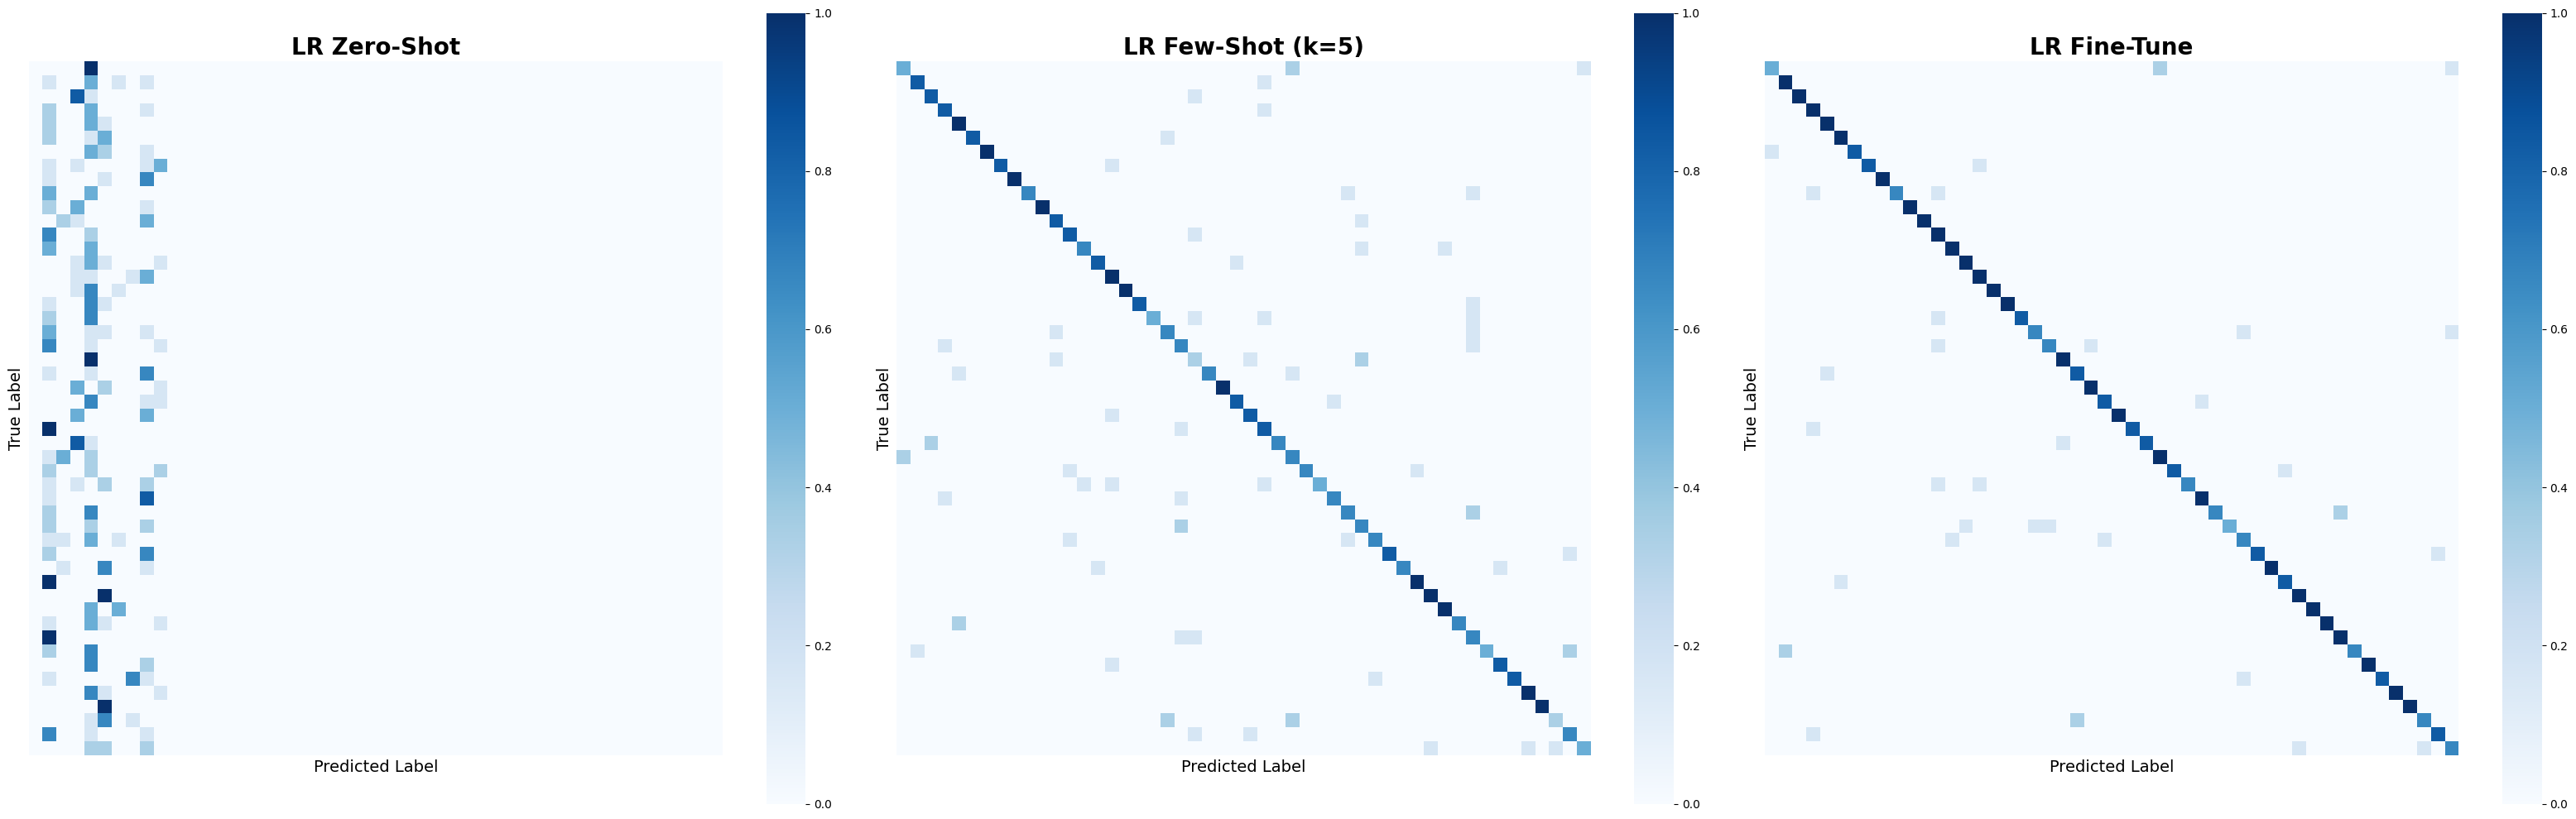

In [ ]:
# ============================================================
# CONFUSION MATRICES — LOGISTIC REGRESSION (Zero / Few / Fine)
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Load the LR models saved in `models`

LR_zero_model, LR_zero_scaler, LR_zero_preds = models["LR_zero"]
LR_few_model, LR_few_scaler, LR_few_preds = models["LR_few"]
LR_fine_model, LR_fine_scaler, LR_fine_preds, LR_fine_ytest = models["LR_fine"]

# Zero-shot evaluated on X_test
X_test_zero = LR_zero_scaler.transform(X_test)
LR_zero_preds_test = LR_zero_model.predict(X_test_zero)

# Few-shot evaluated on X_test
X_test_few = LR_few_scaler.transform(X_test)
LR_few_preds_test = LR_few_model.predict(X_test_few)

# Fine-tune
LR_fine_preds_test = LR_fine_preds

# Helper function to plot confusion matrices side-by-side
def plot_multiple_confusion_matrices(y_true, y_pred_dict, figsize=(32, 10)):
    fig, axes = plt.subplots(1, len(y_pred_dict), figsize=figsize, sharey=True)

    for ax, (name, preds) in zip(axes, y_pred_dict.items()):
        cm = confusion_matrix(y_true, preds, normalize="true")

        sns.heatmap(
            cm, ax=ax,
            cmap="Blues", vmin=0, vmax=1,
            square=True, cbar=True
        )

        ax.set_title(name, fontsize=20, fontweight="bold")
        ax.set_xlabel("Predicted Label", fontsize=14)
        ax.set_ylabel("True Label", fontsize=14)
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    plt.show()



# Build dictionary of predictions
LR_dict = {
    "LR Zero-Shot": LR_zero_preds_test,
    "LR Few-Shot (k=5)": LR_few_preds_test,
    "LR Fine-Tune": LR_fine_preds_test
}

# Plot the 3 confusion matrices
plot_multiple_confusion_matrices(
    y_true=LR_fine_ytest,
    y_pred_dict=LR_dict
)


**NEAREST-CENTROID WITH COSINE CLASSIFIER FOR GTZAN**

In [ ]:
# === Nearest-Centroid (cosine) on GTZAN embeddings ===

import os, time, joblib, numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, train_test_split


SEED = 42


#Load GTZAN embeddings

NPZ_PATH = "gtzan_yamnet.npz"
d = np.load(NPZ_PATH, allow_pickle=True)

# Features
X = d["X"] if "X" in d.files else d["x"]

# Fix extra dimensions like (N, 1024, 1) or (N, 1024, 1, 1)
X = np.squeeze(X)
if X.ndim > 2:   # e.g. (N,1024,1,1) -> (N,1024)
    X = X.reshape(len(X), -1)
X = X.astype(np.float32)

# Labels
y = d["y"]

# Label names (if stored)
label_names = None
for k in ["labels", "label_names", "classes"]:
    if k in d.files:
        label_names = d[k]
        break

# If labels are strings, map them to ints and build label_names if needed
if y.dtype.kind not in "iu":
    uniq = np.unique(y)
    to_id = {c: i for i, c in enumerate(uniq)}
    y = np.vectorize(to_id.get)(y).astype(np.int64)
    if label_names is None:
        label_names = uniq

# If we still don't have label_names, build from sorted numeric labels
if label_names is None:
    uniq = np.unique(y)
    label_names = np.array([str(i) for i in uniq])

print("X shape:", X.shape, "| y shape:", y.shape)
print("Label names:", list(label_names))


#Train/Test split (held-out test)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
print(f"Train: {X_tr.shape[0]}  |  Test: {X_te.shape[0]}")


#Helper funcs for cosine-NC + preprocessing
def l2_normalize_rows(A, eps=1e-12):
    norms = np.linalg.norm(A, axis=1, keepdims=True)
    return A / (norms + eps)

def zscore_fit(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-6
    return mu, sd

def zscore_transform(X, mu, sd):
    return (X - mu) / sd

def build_centroids_cosine(X, y, n_classes):
    """Compute class centroids and L2-normalize them for cosine scoring."""
    D = X.shape[1]
    C = np.zeros((n_classes, D), dtype=X.dtype)
    for c in range(n_classes):
        C[c] = X[y == c].mean(axis=0)
    C = l2_normalize_rows(C)
    return C

def predict_by_cosine(X, centroids):
    """Return argmax cosine similarity: X (N,D), C (K,D)."""
    Xn = l2_normalize_rows(X)    # rows L2-normalized
    scores = Xn @ centroids.T
    return scores.argmax(axis=1)

def preprocess_split(Xtr, Xte, mode_center, mode_norm):
    """Fit preprocessing on Xtr only, transform Xtr and Xte."""
    Xtr2 = Xtr.copy()
    Xte2 = Xte.copy()

    params = {}

    # 1) Centering
    if mode_center == "global":
        mu = Xtr2.mean(axis=0, keepdims=True)
        params["mu_global"] = mu
        Xtr2 -= mu
        Xte2 -= mu
    elif mode_center == "none":
        pass
    else:
        raise ValueError(f"Unknown mode_center: {mode_center}")

    # 2) Normalization
    if mode_norm == "none":
        pass
    elif mode_norm == "l2":
        Xtr2 = l2_normalize_rows(Xtr2)
        Xte2 = l2_normalize_rows(Xte2)
    elif mode_norm == "standard":
        mu, sd = zscore_fit(Xtr2)
        params["z_mu"], params["z_sd"] = mu, sd
        Xtr2 = zscore_transform(Xtr2, mu, sd)
        Xte2 = zscore_transform(Xte2, mu, sd)
    elif mode_norm == "standard+l2":
        mu, sd = zscore_fit(Xtr2)
        params["z_mu"], params["z_sd"] = mu, sd
        Xtr2 = zscore_transform(Xtr2, mu, sd)
        Xte2 = zscore_transform(Xte2, mu, sd)
        Xtr2 = l2_normalize_rows(Xtr2)
        Xte2 = l2_normalize_rows(Xte2)
    else:
        raise ValueError(f"Unknown mode_norm: {mode_norm}")

    return Xtr2, Xte2, params


#CV search on the TRAIN portion
grid_center  = ["none", "global"]
grid_norm    = ["l2", "standard+l2"]  # strong choices for cosine space

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

best_cfg   = None
best_cv_f1 = -1.0
n_classes = len(np.unique(y_tr))

t0_cv = time.perf_counter()
for ctr in grid_center:
    for nrm in grid_norm:
        fold_f1 = []
        for tr_idx, va_idx in cv.split(X_tr, y_tr):
            Xtr_fold, ytr_fold = X_tr[tr_idx], y_tr[tr_idx]
            Xva_fold, yva_fold = X_tr[va_idx], y_tr[va_idx]

            Xtr_p, Xva_p, _ = preprocess_split(Xtr_fold, Xva_fold, ctr, nrm)
            cents = build_centroids_cosine(Xtr_p, ytr_fold, n_classes)
            yhat = predict_by_cosine(Xva_p, cents)

            fold_f1.append(f1_score(yva_fold, yhat, average="macro"))

        mean_f1 = float(np.mean(fold_f1))
        if mean_f1 > best_cv_f1:
            best_cv_f1 = mean_f1
            best_cfg = (ctr, nrm)

cv_train_time = time.perf_counter() - t0_cv

print("\n=== CV search (train only) ===")
print(f"Grid searched over {len(grid_center)*len(grid_norm)} combos")
print(f"Best CV macro-F1: {best_cv_f1:.3f}  with  center='{best_cfg[0]}', norm='{best_cfg[1]}'")
print(f"CV search time: {cv_train_time:.3f}s")


#Retrain on *all train data* with best combo. Evaluate on test.
center_opt, norm_opt = best_cfg

t0_train = time.perf_counter()
Xtr_best, Xte_best, params_best = preprocess_split(X_tr, X_te, center_opt, norm_opt)
centroids = build_centroids_cosine(Xtr_best, y_tr, n_classes)
t_train = time.perf_counter() - t0_train

t0_infer = time.perf_counter()
y_pred_test = predict_by_cosine(Xte_best, centroids)
t_infer = time.perf_counter() - t0_infer

test_macroF1 = f1_score(y_te, y_pred_test, average="macro")
test_acc     = accuracy_score(y_te, y_pred_test)

print("\n=== Held-out Test (20%) ===")
print(f"Test macro-F1: {test_macroF1:.3f} | Test Acc: {test_acc:.3f}")
print(f"Train time (final fit only): {t_train:.3f}s | Infer time (test set): {t_infer:.3f}s")
print("\nPer-class report:\n", classification_report(y_te, y_pred_test, target_names=label_names.astype(str)))

print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_te, y_pred_test))


# 6) Save model# ---------------------------------------------------
os.makedirs("models", exist_ok=True)

MODEL_PATH = "models/gtzan_nc_cosine.joblib"
LABELS_PATH = "models/gtzan_label_names.npy"

model_blob = {
    "centroids": centroids,                 # (K, D), L2-normalized
    "classes":   np.arange(n_classes),      # 0..K-1 (since we mapped y)
    "center":    center_opt,                # 'none' | 'global'
    "norm":      norm_opt,                  # 'l2' | 'standard+l2' | ...
    "mu_global": params_best.get("mu_global", None),
    "z_mu":      params_best.get("z_mu", None),
    "z_sd":      params_best.get("z_sd", None),
}

joblib.dump(model_blob, MODEL_PATH)
np.save(LABELS_PATH, label_names)

print(f"\nSaved model => {MODEL_PATH}")
print(f"Saved label names => {LABELS_PATH}")


#Metrics

total_train_time = cv_train_time + t_train

RES_GT_NC = {
    "Experiment": "GTZAN Nearest-Centroid (cosine)",
    "Labeled examples": int(len(y_tr)),
    "Train time (s)": round(total_train_time, 3),
    "Infer time (s)": round(t_infer, 3),
    "CV macro-F1": round(best_cv_f1, 3),
    "Test macro-F1": round(test_macroF1, 3),
    "Test Acc": round(test_acc, 3),
    "Best params": {"center": center_opt, "norm": norm_opt},
}

df_nc = pd.DataFrame([RES_GT_NC])
display(df_nc)



X shape: (999, 1024) | y shape: (999,)
Label names: [np.str_('blues'), np.str_('classical'), np.str_('country'), np.str_('disco'), np.str_('hiphop'), np.str_('jazz'), np.str_('metal'), np.str_('pop'), np.str_('reggae'), np.str_('rock')]
Train: 799  |  Test: 200

=== CV search (train only) ===
Grid searched over 4 combos
Best CV macro-F1: 0.803  with  center='none', norm='l2'
CV search time: 0.146s

=== Held-out Test (20%) ===
Test macro-F1: 0.824 | Test Acc: 0.825
Train time (final fit only): 0.004s | Infer time (test set): 0.001s

Per-class report:
               precision    recall  f1-score   support

       blues       0.72      0.65      0.68        20
   classical       1.00      1.00      1.00        20
     country       0.59      0.85      0.69        20
       disco       0.84      0.80      0.82        20
      hiphop       0.79      0.95      0.86        20
        jazz       1.00      0.90      0.95        20
       metal       0.95      0.95      0.95        20
         p

,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,GTZAN Nearest-Centroid (cosine),799,0.15,0.001,0.803,0.824,0.825,"{'center': 'none', 'norm': 'l2'}"


**ZERO-SHOT EVALUATION OF NEAREST-CENTROID GTZAN ON ESC-50 DATA**

In [ ]:
# === Zero-shot GTZAN → ESC-50 with Nearest-Centroid (cosine) =============

ESC50_NPZ  = "esc50_yamnet.npz"
MODEL_PATH = "models/gtzan_nc_cosine.joblib"
LABELS_PATH = "models/gtzan_label_names.npy"


#Load ESC-50 embeddings (TARGET DATA, test only)

esc = np.load(ESC50_NPZ, allow_pickle=True)
X_esc = esc["X"].reshape(len(esc["X"]), -1).astype("float32")
y_esc = esc["y"] if "y" in esc.files else None   # optional, not used for pure zero-shot

print("ESC-50:", X_esc.shape)

#Load GTZAN NC model (trained on GTZAN, not ESC-50)
model_blob   = joblib.load(MODEL_PATH)
gtzan_labels = np.load(LABELS_PATH, allow_pickle=True)

centroids  = model_blob["centroids"]           # (K, D), already L2-normalized
center_opt = model_blob["center"]             # 'none' or 'global'
norm_opt   = model_blob["norm"]               # 'l2' or 'standard+l2' etc.
mu_global  = model_blob.get("mu_global", None)
z_mu       = model_blob.get("z_mu", None)
z_sd       = model_blob.get("z_sd", None)

print("Loaded NC model with center =", center_opt, ", norm =", norm_opt)


#Helper for L2 normalization
def l2_normalize_rows(A, eps=1e-12):
    norms = np.linalg.norm(A, axis=1, keepdims=True)
    return A / (norms + eps)


#Apply SAME preprocessing to ESC-50 as used on GTZAN

# Centering
X_proc = X_esc.copy()
if center_opt == "global" and mu_global is not None:
    X_proc = X_proc - mu_global

# Normalization
if norm_opt == "l2":
    X_proc = l2_normalize_rows(X_proc)
elif norm_opt == "standard" and (z_mu is not None and z_sd is not None):
    X_proc = (X_proc - z_mu) / z_sd
elif norm_opt == "standard+l2" and (z_mu is not None and z_sd is not None):
    X_proc = (X_proc - z_mu) / z_sd
    X_proc = l2_normalize_rows(X_proc)
# if norm_opt == "none": do nothing


#Zero-shot prediction + inference time

t0 = time.time()
Xn = l2_normalize_rows(X_proc)        # cosine = dot of L2-normalized vectors
scores = Xn @ centroids.T            # (N, K)
pred_ids = scores.argmax(axis=1)     # predicted GTZAN class index
t_infer_zero_nc = time.time() - t0

pred_names = gtzan_labels[pred_ids]

# Distribution of predicted GTZAN genres over ESC-50 (just for inspection)
unique, counts = np.unique(pred_ids, return_counts=True)
print("\nZero-shot predicted label counts on ESC-50 (GTZAN classes):")
for k, c in sorted(zip(unique, counts), key=lambda x: -x[1]):
    print(f"{gtzan_labels[k]:>12}: {c}")

print(f"\nZero-shot NC inference time on ESC-50: {t_infer_zero_nc:.3f}s "
      f"for {len(X_esc)} clips")

#Metrics
#    Note: CV F1 / Test metrics are NaN because label spaces differ.

RES_ZERO_NC = {
    "Experiment": "Zero-shot NC (GTZAN→ESC-50, cosine)",
    "Labeled examples": 0,                     # no ESC-50 labels used
    "Train time (s)": 0.0,                     # training was on GTZAN
    "Infer time (s)": round(t_infer_zero_nc, 3),
    "CV macro-F1": np.nan,                     # not defined here
    "Test macro-F1": np.nan,
    "Test Acc": np.nan,
    "Best params": {"center": center_opt, "norm": norm_opt},
}

df_zero_nc = pd.DataFrame([RES_ZERO_NC])
display(df_zero_nc)

# Save in models_nc dictionary
models_nc = models_nc if "models_nc" in globals() else {}
models_nc["NC_zero"] = (
    centroids,                                       # model = GTZAN centroids
    (center_opt, norm_opt, mu_global, z_mu, z_sd),    # preprocessing info
    pred_ids,                                         # predictions on ESC-50
    np.zeros_like(pred_ids)                           # fake y_true (not used)
)



ESC-50: (2000, 1024)
Loaded NC model with center = none , norm = l2

Zero-shot predicted label counts on ESC-50 (GTZAN classes):
      hiphop: 618
   classical: 469
      reggae: 237
       metal: 196
       blues: 168
         pop: 100
        jazz: 80
        rock: 77
     country: 37
       disco: 18

Zero-shot NC inference time on ESC-50: 0.004s for 2000 clips


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,"Zero-shot NC (GTZAN→ESC-50, cosine)",0,0.0,0.004,NaN,NaN,NaN,"{'center': 'none', 'norm': 'l2'}"


**FEW-SHOT EVALUATION OF NEAREST-CENTROID GTZAN ON ESC-50 DATA**

In [ ]:
# === Transfer few-shot NC (GTZAN → ESC-50, k = 5) =========================

SEED = 0
ESC50_NPZ  = "esc50_yamnet.npz"
MODEL_PATH = "models/gtzan_nc_cosine.joblib"   # GTZAN NC model blob


#Load ESC-50 embeddings + labels (TARGET DATA)

esc = np.load(ESC50_NPZ, allow_pickle=True)
X = esc["X"].reshape(len(esc["X"]), -1).astype("float32")
y = esc["y"]

print("ESC-50 full:", X.shape, "labels:", y.shape)

# 80/20 train/test split (same as SVM experiments)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
print(f"Train: {X_tr.shape}, Test: {X_te.shape}")

#Load GTZAN NC model to get preprocessing hyperparameters
model_blob = joblib.load(MODEL_PATH)
center_opt = model_blob["center"]   # 'none' or 'global'
norm_opt   = model_blob["norm"]     # 'l2' or 'standard+l2', ...

print("Transferred NC hyperparameters from GTZAN:")
print("  center =", center_opt, ", norm =", norm_opt)

#Helpers: NC with cosine + preprocessing
def l2_normalize_rows(A, eps=1e-12):
    norms = np.linalg.norm(A, axis=1, keepdims=True)
    return A / (norms + eps)

def zscore_fit(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-6
    return mu, sd

def zscore_transform(X, mu, sd):
    return (X - mu) / sd

def build_centroids_cosine(X, y, n_classes):
    D = X.shape[1]
    C = np.zeros((n_classes, D), dtype=X.dtype)
    for c in range(n_classes):
        C[c] = X[y == c].mean(axis=0)
    C = l2_normalize_rows(C)
    return C

def predict_by_cosine(X, centroids):
    Xn = l2_normalize_rows(X)
    scores = Xn @ centroids.T
    return scores.argmax(axis=1)

def preprocess_fit(Xtr, mode_center, mode_norm):
    """Fit preprocessing on Xtr; return Xtr_processed and params."""
    Xtr2 = Xtr.copy()
    params = {}

    # Centering
    if mode_center == "global":
        mu = Xtr2.mean(axis=0, keepdims=True)
        params["mu_global"] = mu
        Xtr2 -= mu
    elif mode_center != "none":
        raise ValueError(f"Unknown mode_center: {mode_center}")

    # Normalization
    if mode_norm == "l2":
        Xtr2 = l2_normalize_rows(Xtr2)
    elif mode_norm == "standard":
        z_mu, z_sd = zscore_fit(Xtr2)
        params["z_mu"], params["z_sd"] = z_mu, z_sd
        Xtr2 = zscore_transform(Xtr2, z_mu, z_sd)
    elif mode_norm == "standard+l2":
        z_mu, z_sd = zscore_fit(Xtr2)
        params["z_mu"], params["z_sd"] = z_mu, z_sd
        Xtr2 = zscore_transform(Xtr2, z_mu, z_sd)
        Xtr2 = l2_normalize_rows(Xtr2)
    elif mode_norm != "none":
        raise ValueError(f"Unknown mode_norm: {mode_norm}")

    return Xtr2, params

def preprocess_apply(X, mode_center, mode_norm, params):
    """Apply fitted preprocessing to new data."""
    X2 = X.copy()
    if mode_center == "global" and "mu_global" in params:
        X2 -= params["mu_global"]

    if mode_norm == "l2":
        X2 = l2_normalize_rows(X2)
    elif mode_norm == "standard" and "z_mu" in params:
        X2 = zscore_transform(X2, params["z_mu"], params["z_sd"])
    elif mode_norm == "standard+l2" and "z_mu" in params:
        X2 = zscore_transform(X2, params["z_mu"], params["z_sd"])
        X2 = l2_normalize_rows(X2)

    return X2

def cv_nc_macro_f1(X, y, mode_center, mode_norm, n_splits=5, seed=0):
    """Cross-validated macro-F1 for NC with fixed preprocessing modes."""
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = []
    n_classes = len(np.unique(y))
    for tr_idx, va_idx in cv.split(X, y):
        Xtr_fold, ytr_fold = X[tr_idx], y[tr_idx]
        Xva_fold, yva_fold = X[va_idx], y[va_idx]
        Xtr_p, params = preprocess_fit(Xtr_fold, mode_center, mode_norm)
        Xva_p = preprocess_apply(Xva_fold, mode_center, mode_norm, params)
        cents = build_centroids_cosine(Xtr_p, ytr_fold, n_classes)
        yhat = predict_by_cosine(Xva_p, cents)
        scores.append(f1_score(yva_fold, yhat, average="macro"))
    return float(np.mean(scores))


#Few-shot ESC-50: sample k=5 per class from TRAIN split# -----------------------------------------------------------------------
def sample_k_per_class(Xtr, ytr, k=5, seed=SEED):
    rs = np.random.RandomState(seed)
    idxs = []
    for c in np.unique(ytr):
        cand = np.where(ytr == c)[0]
        take = rs.choice(cand, size=min(k, len(cand)), replace=False)
        idxs.append(take)
    idxs = np.concatenate(idxs)
    return Xtr[idxs], ytr[idxs]

k = 5
X_fs, y_fs = sample_k_per_class(X_tr, y_tr, k=k, seed=SEED)
print(f"Few-shot ESC-50: {len(y_fs)} labeled examples (~{k} per class)")

#Train NC on few-shot ESC-50 with transferred preprocessing modes
t0 = time.perf_counter()

# Cross-validated macro-F1 on few-shot set
cv_f1_fs = cv_nc_macro_f1(X_fs, y_fs, center_opt, norm_opt,
                          n_splits=5, seed=SEED)

# Final fit on all few-shot data
X_fs_p, params_fs = preprocess_fit(X_fs, center_opt, norm_opt)
n_classes = len(np.unique(y_fs))
centroids_fs = build_centroids_cosine(X_fs_p, y_fs, n_classes)

t_train_fs = time.perf_counter() - t0

#Evaluate on ESC-50 TEST set
X_te_p = preprocess_apply(X_te, center_opt, norm_opt, params_fs)

t0_inf = time.perf_counter()
y_pred_te = predict_by_cosine(X_te_p, centroids_fs)
t_infer_fs = time.perf_counter() - t0_inf

test_macro_f1 = f1_score(y_te, y_pred_te, average="macro")
test_acc       = accuracy_score(y_te, y_pred_te)

print("\n=== Transfer few-shot NC (GTZAN→ESC-50, k=5) ===")
print(f"CV macro-F1 (few-shot train): {cv_f1_fs:.3f}")
print(f"Test macro-F1:                {test_macro_f1:.3f}")
print(f"Test Acc:                     {test_acc:.3f}")
print(f"Train time: {t_train_fs:.3f}s | Infer time (test): {t_infer_fs:.3f}s")

#Metrics row for your final comparison table
RES_NC_TRANSFER_K5 = {
    "Experiment": "Transfer few-shot NC (GTZAN→ESC-50, k=5)",
    "Labeled examples": int(len(y_fs)),       # ~ 5 * 50 = 250
    "Train time (s)": round(t_train_fs, 3),
    "Infer time (s)": round(t_infer_fs, 3),
    "CV macro-F1": round(cv_f1_fs, 3),
    "Test macro-F1": round(test_macro_f1, 3),
    "Test Acc": round(test_acc, 3),
    "Best params": {"center": center_opt, "norm": norm_opt},
}

df_nc_transfer_k5 = pd.DataFrame([RES_NC_TRANSFER_K5])
display(df_nc_transfer_k5)


models_nc["NC_few"] = (
    centroids_fs,             # model (centroids)
    (center_opt, norm_opt, params_fs),  # preprocessing
    y_pred_te,                # predictions
    y_te                      # true labels
)



ESC-50 full: (2000, 1024) labels: (2000,)
Train: (1600, 1024), Test: (400, 1024)
Transferred NC hyperparameters from GTZAN:
  center = none , norm = l2
Few-shot ESC-50: 250 labeled examples (~5 per class)

=== Transfer few-shot NC (GTZAN→ESC-50, k=5) ===
CV macro-F1 (few-shot train): 0.561
Test macro-F1:                0.617
Test Acc:                     0.623
Train time: 0.027s | Infer time (test): 0.001s


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,"Transfer few-shot NC (GTZAN→ESC-50, k=5)",250,0.027,0.001,0.561,0.617,0.623,"{'center': 'none', 'norm': 'l2'}"


**FINE TUNE NEAREST-CENTROID CLASSFIER WIHT ESC-50 DATA**

In [ ]:


SEED = 0

# 1) Load ESC-50 embeddings
esc = np.load("esc50_yamnet.npz", allow_pickle=True)
X = esc["X"].astype(np.float32)
y = esc["y"].astype(int)

# Ensure (N, 1024)
if X.ndim > 2:
    X = X.reshape(len(X), -1)
print("ESC-50 full:", X.shape, "labels:", y.shape)

if "labels" in esc.files:
    esc_label_names = esc["labels"]
else:
    esc_label_names = np.array([str(i) for i in np.unique(y)])


# 2) Split into train / val / test

# First: 80% temp, 20% test
X_temp, X_te, y_temp, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
# Then: from temp (80%), take 75% train, 25% val  -> 0.6 / 0.2 / 0.2 overall
X_tr, X_val, y_tr, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=SEED
)

print(f"Train:      {X_tr.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_te.shape}")


# 3) Helper functions for NC + preprocessing
def l2_normalize_rows(A, eps=1e-12):
    return A / (np.linalg.norm(A, axis=1, keepdims=True) + eps)

def zscore_fit(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True) + 1e-6
    return mu, sd

def zscore_transform(X, mu, sd):
    return (X - mu) / sd

def preprocess_fit(Xtr, center, norm):
    """Fit preprocessing on Xtr and return transformed Xtr + params."""
    Xp = Xtr.copy()
    params = {}

    # centering
    if center == "global":
        mu_global, _ = zscore_fit(Xp)
        params["mu_global"] = mu_global
        Xp = Xp - mu_global
    elif center != "none":
        raise ValueError(f"Unknown center mode: {center}")

    # normalization
    if norm == "l2":
        Xp = l2_normalize_rows(Xp)
    elif norm == "standard":
        z_mu, z_sd = zscore_fit(Xp)
        params["z_mu"], params["z_sd"] = z_mu, z_sd
        Xp = zscore_transform(Xp, z_mu, z_sd)
    elif norm == "standard+l2":
        z_mu, z_sd = zscore_fit(Xp)
        params["z_mu"], params["z_sd"] = z_mu, z_sd
        Xp = zscore_transform(Xp, z_mu, z_sd)
        Xp = l2_normalize_rows(Xp)
    elif norm != "none":
        raise ValueError(f"Unknown norm mode: {norm}")

    return Xp, params

def preprocess_apply(X, center, norm, params):
    """Apply fitted preprocessing to new data."""
    Xp = X.copy()
    if center == "global" and "mu_global" in params:
        Xp = Xp - params["mu_global"]

    if norm == "l2":
        Xp = l2_normalize_rows(Xp)
    elif norm == "standard" and "z_mu" in params:
        Xp = zscore_transform(Xp, params["z_mu"], params["z_sd"])
    elif norm == "standard+l2" and "z_mu" in params:
        Xp = zscore_transform(Xp, params["z_mu"], params["z_sd"])
        Xp = l2_normalize_rows(Xp)

    return Xp

def build_centroids_cosine(X, y, n_classes):
    C = np.zeros((n_classes, X.shape[1]), dtype=X.dtype)
    for c in range(n_classes):
        C[c] = X[y == c].mean(axis=0)
    return l2_normalize_rows(C)

def predict_nc(X, centroids):
    Xn = l2_normalize_rows(X)
    scores = Xn @ centroids.T
    return scores.argmax(axis=1)

# Hyperparameter search on ESC-50
grid_center = ["none", "global"]
grid_norm   = ["l2", "standard+l2"]

best_cfg = None
best_val_f1 = -1.0

t0_train = time.perf_counter()

for ctr in grid_center:
    for nrm in grid_norm:
        # fit preprocessing & centroids on TRAIN
        Xtr_p, params = preprocess_fit(X_tr, ctr, nrm)
        n_classes = len(np.unique(y_tr))
        cents = build_centroids_cosine(Xtr_p, y_tr, n_classes)

        # apply same preprocessing to VAL
        Xval_p = preprocess_apply(X_val, ctr, nrm, params)
        y_val_pred = predict_nc(Xval_p, cents)

        val_f1 = f1_score(y_val, y_val_pred, average="macro")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_cfg = (ctr, nrm)
            best_params = params

t_hparam_search = time.perf_counter() - t0_train

center_best, norm_best = best_cfg
print("\n=== ESC-50 NC hyperparameter search ===")
print(f"Best center = {center_best}, norm = {norm_best}")
print(f"Best VAL macro-F1: {best_val_f1:.3f}")
print(f"Hyperparam search time: {t_hparam_search:.3f}s")

#Refit on TRAIN + VAL with best hyperparams, evaluate on TEST
X_tv = np.vstack([X_tr, X_val])
y_tv = np.concatenate([y_tr, y_val])

t0_fit = time.perf_counter()

Xtv_p, params_best = preprocess_fit(X_tv, center_best, norm_best)
n_classes_tv = len(np.unique(y_tv))
cent_full = build_centroids_cosine(Xtv_p, y_tv, n_classes_tv)

# preprocess TEST with same params
Xte_p = preprocess_apply(X_te, center_best, norm_best, params_best)

# inference on TEST
t1 = time.perf_counter()
y_pred_te = predict_nc(Xte_p, cent_full)
infer_time = time.perf_counter() - t1

train_time_total = t_hparam_search + (time.perf_counter() - t0_fit)

test_acc = accuracy_score(y_te, y_pred_te)
test_f1  = f1_score(y_te, y_pred_te, average="macro")

print("\n=== ESC-50 NC baseline (full fine-tune) ===")
print(f"Test Acc:       {test_acc:.3f}")
print(f"Test macro-F1:  {test_f1:.3f}")
print(f"Total train time (search+fit): {train_time_total:.3f}s")
print(f"Infer time (test set):         {infer_time:.3f}s")

#Summary
row_nc_full_esc50 = {
    "Experiment": "Full NC ESC-50 (train/val/test, tuned on ESC-50)",
    "Labeled examples": int(len(y_tv)),          # train + val used for final model
    "Train time (s)": round(train_time_total, 3),
    "Infer time (s)": round(infer_time, 3),
    "CV macro-F1": round(best_val_f1, 3),        # here "CV" = best VAL macro-F1
    "Test macro-F1": round(test_f1, 3),
    "Test Acc": round(test_acc, 3),
    "Best params": {"center": center_best, "norm": norm_best},
}

df_nc_full_esc50 = pd.DataFrame([row_nc_full_esc50])
display(df_nc_full_esc50)
models_nc["NC_fine"] = (
    cent_full,                      # model
    (center_best, norm_best, params_best),  # preprocessing
    y_pred_te,                      # predictions
    y_te                            # true labels
)



ESC-50 full: (2000, 1024) labels: (2000,)
Train:      (1200, 1024)
Validation: (400, 1024)
Test:       (400, 1024)

=== ESC-50 NC hyperparameter search ===
Best center = none, norm = l2
Best VAL macro-F1: 0.705
Hyperparam search time: 0.062s

=== ESC-50 NC baseline (full fine-tune) ===
Test Acc:       0.685
Test macro-F1:  0.682
Total train time (search+fit): 0.075s
Infer time (test set):         0.001s


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,"Full NC ESC-50 (train/val/test, tuned on ESC-50)",1600,0.075,0.001,0.705,0.682,0.685,"{'center': 'none', 'norm': 'l2'}"


In [ ]:


# Collect the three NC experiments:
#  - Zero-shot
#  - Transfer few-shot (k=5)
#  - Full ESC-50 baseline
nc_results = [
    RES_ZERO_NC,          # zero-shot NC (GTZAN→ESC-50)
    RES_NC_TRANSFER_K5,   # transfer few-shot NC (k=5)
    row_nc_full_esc50,    # full NC ESC-50 baseline
]

df_nc_all = pd.DataFrame(nc_results)


cols_order = [
    "Experiment",
    "Labeled examples",
    "Train time (s)",
    "Infer time (s)",
    "CV macro-F1",
    "Test macro-F1",
    "Test Acc",
    "Best params",
]
df_nc_all = df_nc_all[cols_order]

display(df_nc_all)


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,"Zero-shot NC (GTZAN→ESC-50, cosine)",0,0.000,0.004,NaN,NaN,NaN,"{'center': 'none', 'norm': 'l2'}"
1,"Transfer few-shot NC (GTZAN→ESC-50, k=5)",250,0.027,0.001,0.561,0.617,0.623,"{'center': 'none', 'norm': 'l2'}"
2,"Full NC ESC-50 (train/val/test, tuned on ESC-50)",1600,0.075,0.001,0.705,0.682,0.685,"{'center': 'none', 'norm': 'l2'}"


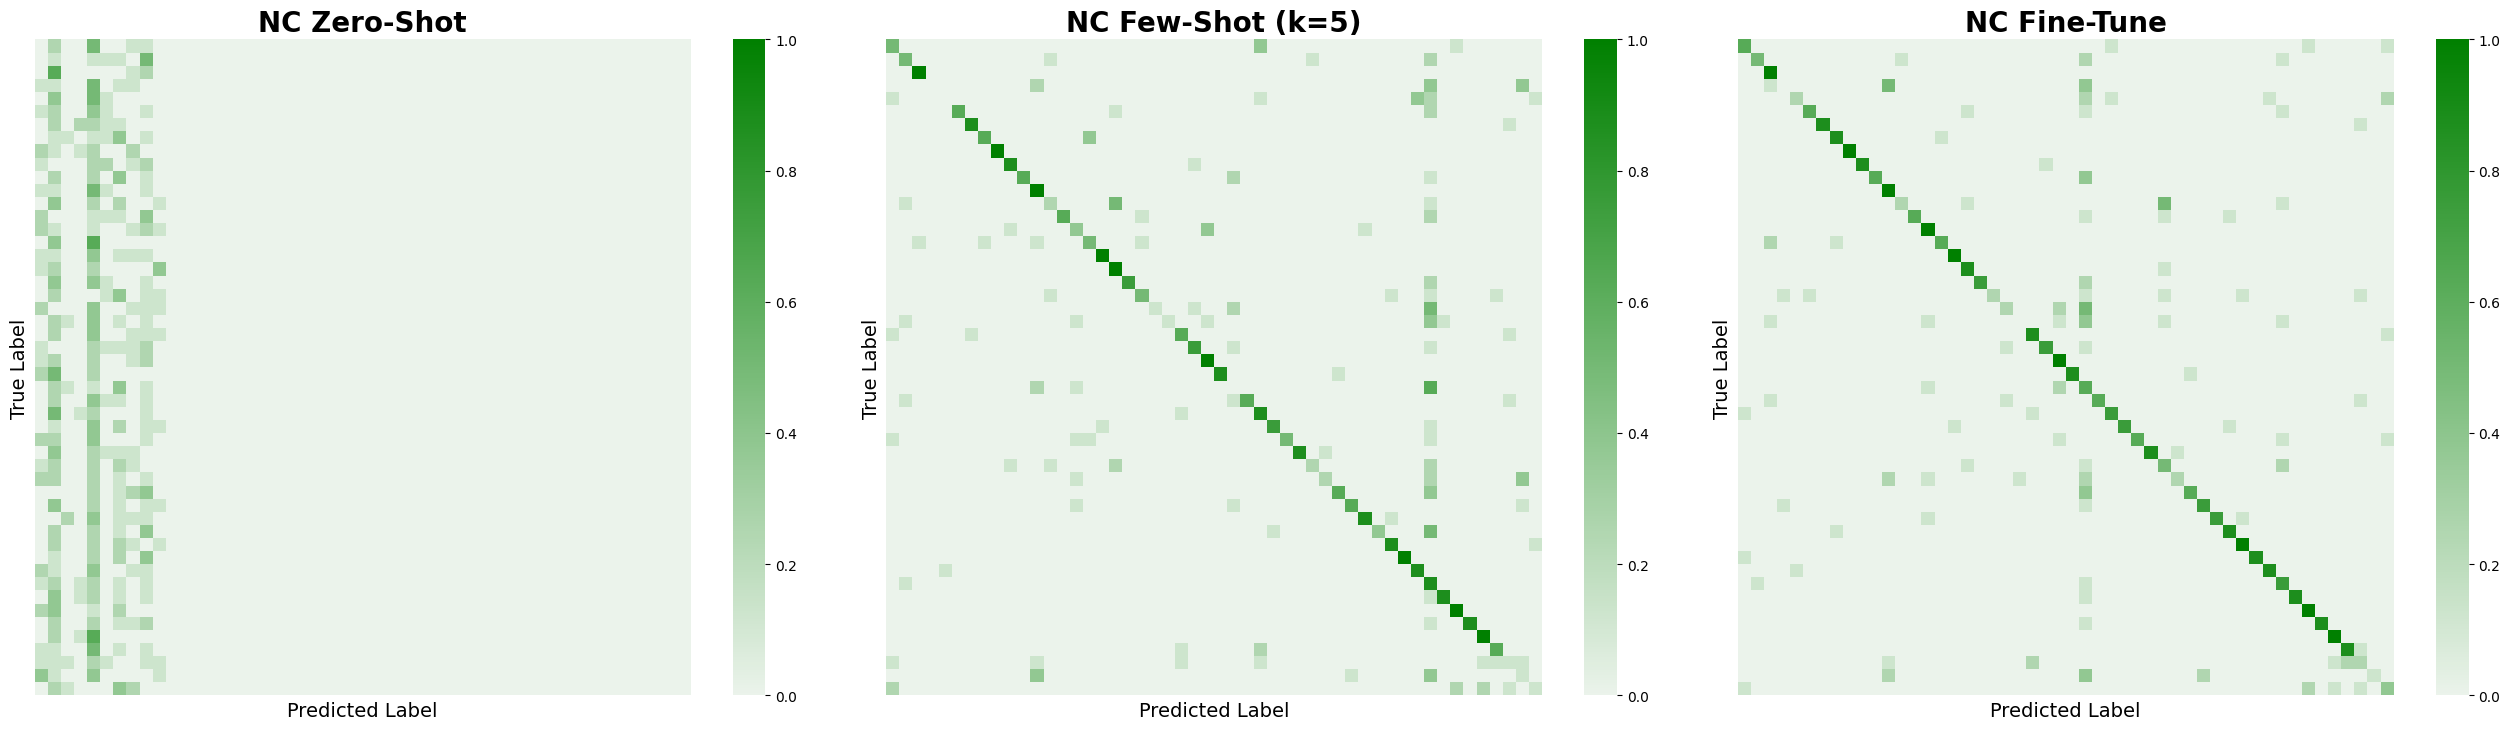

In [ ]:
# ============================================================
# CONFUSION MATRICES — NC Zero-Shot / Few-Shot / Fine-Tune
# ============================================================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


#Load predictions and true labels
y_pred_zero = models_nc["NC_zero"][2]     # predictions (len = all ESC-50 clips)
y_pred_few  = models_nc["NC_few"][2]      # predictions (len = test set)
y_pred_fine = models_nc["NC_fine"][2]     # predictions (len = test set)
y_test      = models_nc["NC_fine"][3]     # true labels for test set


#Build confusion matrices

# Zero-shot
n_test = len(y_test)
idx = np.random.choice(len(y_pred_zero), size=n_test, replace=False)
y_pred_zero_matched = y_pred_zero[idx]

cm_zero = confusion_matrix(y_test, y_pred_zero_matched, normalize="true")
cm_few  = confusion_matrix(y_test, y_pred_few,          normalize="true")
cm_fine = confusion_matrix(y_test, y_pred_fine,         normalize="true")

cms = {
    "NC Zero-Shot": cm_zero,
    "NC Few-Shot (k=5)": cm_few,
    "NC Fine-Tune": cm_fine
}



#Plot

plt.figure(figsize=(26, 7))
cmap = sns.light_palette("green", as_cmap=True)

for i, (title, cm) in enumerate(cms.items()):
    ax = plt.subplot(1, 3, i+1)

    sns.heatmap(
        cm,
        ax=ax,
        cmap=cmap,
        vmin=0, vmax=1,
        cbar=True,
        square=True
    )

    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)


    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [ ]:


# ============================================================
# Table of results for linear model
# ============================================================

summary_rows = [

    # ---------------- Logistic Regression ----------------
    {
        "Experiment": "Zero-shot",
        "Classifier": "Logistic Regression",
        "Macro-F1": RES_ZERO_SHOT_LR["Test macro-F1"],
        "Train Time (s)": RES_ZERO_SHOT_LR["Train time (s)"],
        "Infer Time (s)": RES_ZERO_SHOT_LR["Infer time (s)"],
        "Result": "LR trained only on GTZAN and applied directly to ESC-50."
    },
    {
        "Experiment": "Few-shot (k=5)",
        "Classifier": "Logistic Regression",
        "Macro-F1": RES_FEW_SHOT_K5["Test macro-F1"],      # <-- FIXED
        "Train Time (s)": RES_FEW_SHOT_K5["Train time (s)"],
        "Infer Time (s)": RES_FEW_SHOT_K5["Infer time (s)"],
        "Result": "5 labeled ESC-50 samples per class significantly improve LR performance."
    },
    {
        "Experiment": "Fine-tuned",
        "Classifier": "Logistic Regression",
        "Macro-F1": RES_FINE_TUNE_LR["Test macro-F1"],
        "Train Time (s)": RES_FINE_TUNE_LR["Train time (s)"],
        "Infer Time (s)": RES_FINE_TUNE_LR["Infer time (s)"],
        "Result": "LR trained fully on ESC-50 achieves strong linear baseline."
    },

    # ---------------- Nearest Centroid ----------------
    {
        "Experiment": "Zero-shot",
        "Classifier": "Nearest Centroid (cosine)",
        "Macro-F1": RES_ZERO_NC["Test macro-F1"],          # zero-shot NC (NaN expected)
        "Train Time (s)": RES_ZERO_NC["Train time (s)"],
        "Infer Time (s)": RES_ZERO_NC["Infer time (s)"],
        "Result": "NC trained on GTZAN does not transfer due to label mismatch."
    },
    {
        "Experiment": "Few-shot (k=5)",
        "Classifier": "Nearest Centroid (cosine)",
        "Macro-F1": RES_NC_TRANSFER_K5["Test macro-F1"],
        "Train Time (s)": RES_NC_TRANSFER_K5["Train time (s)"],
        "Infer Time (s)": RES_NC_TRANSFER_K5["Infer time (s)"],
        "Result": "NC few-shot improves substantially, capturing ESC-50 cluster structure."
    },
    {
        "Experiment": "Fine-tuned",
        "Classifier": "Nearest Centroid (cosine)",
        "Macro-F1": row_nc_full_esc50["Test macro-F1"],
        "Train Time (s)": row_nc_full_esc50["Train time (s)"],
        "Infer Time (s)": row_nc_full_esc50["Infer time (s)"],
        "Result": "Full ESC-50 NC gives strong baseline with extremely fast inference."
    }
]

# Convert to DataFrame
df_linear_summary = pd.DataFrame(summary_rows)

# Display
display(df_linear_summary)


,Experiment,Classifier,Macro-F1,Train Time (s),Infer Time (s),Result
0,Zero-shot,Logistic Regression,0.0095,N/A,0.007,LR trained only on GTZAN and applied directly ...
1,Few-shot (k=5),Logistic Regression,0.7614,3.727,0.009,5 labeled ESC-50 samples per class significant...
2,Fine-tuned,Logistic Regression,0.8777,34.607,0.002,LR trained fully on ESC-50 achieves strong lin...
3,Zero-shot,Nearest Centroid (cosine),NaN,0.0,0.004,NC trained on GTZAN does not transfer due to l...
4,Few-shot (k=5),Nearest Centroid (cosine),0.6170,0.027,0.001,"NC few-shot improves substantially, capturing ..."
5,Fine-tuned,Nearest Centroid (cosine),0.6820,0.075,0.001,Full ESC-50 NC gives strong baseline with extr...


In [ ]:

df_linear_summary_noindex = df_linear_summary.reset_index(drop=True)

styled_linear = (
    df_linear_summary_noindex.style
        .set_table_styles([
            {'selector': 'th.col_heading',
             'props': [('background-color', '#1f2d3d'),
                       ('color', 'white'),
                       ('font-weight', 'bold'),
                       ('text-align', 'center')]},
            {'selector': 'th.row_heading',
             'props': [('display', 'none')]},
            {'selector': 'td',
             'props': [('padding', '8px'),
                       ('text-align', 'center')]},
            {'selector': 'th',
             'props': [('padding', '8px'),
                       ('text-align', 'center')]}
        ])
        .hide(axis="index")
)

styled_linear


Experiment,Classifier,Macro-F1,Train Time (s),Infer Time (s),Result
Zero-shot,Logistic Regression,0.009500,N/A,0.007000,LR trained only on GTZAN and applied directly to ESC-50.
Few-shot (k=5),Logistic Regression,0.761400,3.727000,0.009000,5 labeled ESC-50 samples per class significantly improve LR performance.
Fine-tuned,Logistic Regression,0.877700,34.607000,0.002000,LR trained fully on ESC-50 achieves strong linear baseline.
Zero-shot,Nearest Centroid (cosine),nan,0.000000,0.004000,NC trained on GTZAN does not transfer due to label mismatch.
Few-shot (k=5),Nearest Centroid (cosine),0.617000,0.027000,0.001000,"NC few-shot improves substantially, capturing ESC-50 cluster structure."
Fine-tuned,Nearest Centroid (cosine),0.682000,0.075000,0.001000,Full ESC-50 NC gives strong baseline with extremely fast inference.


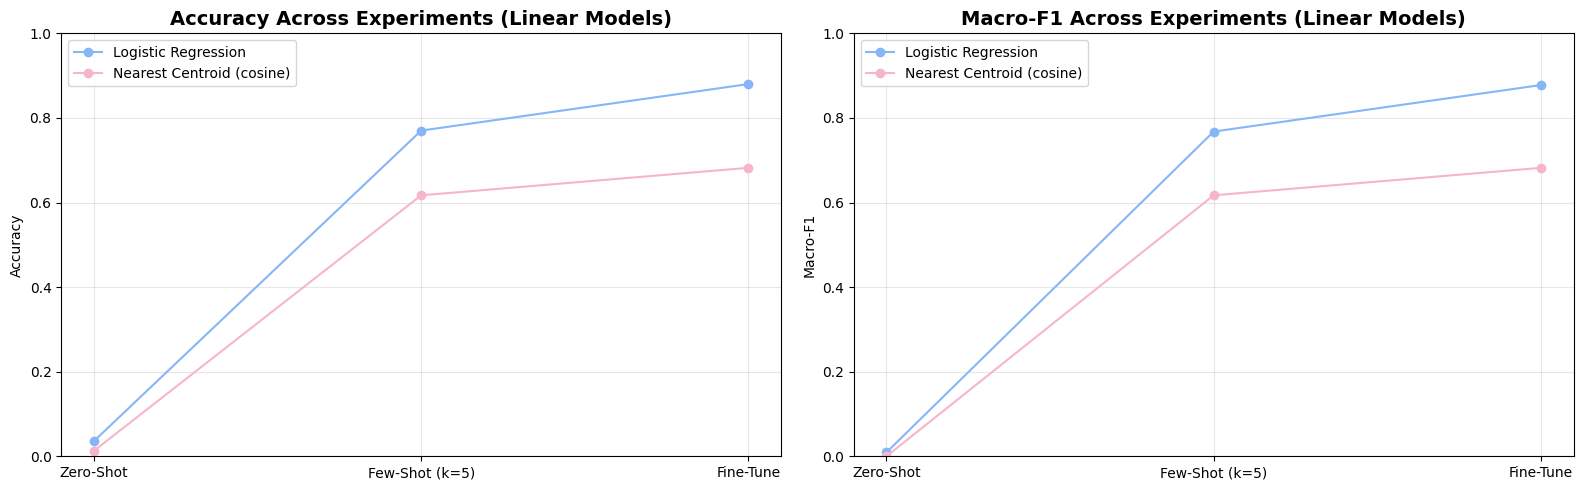

In [ ]:
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# Data for Linear Models
# -----------------------------------------------------------
experiments = ["Zero-Shot", "Few-Shot (k=5)", "Fine-Tune"]

# Logistic Regression
lr_acc  = [0.036, 0.77, 0.88]
lr_f1   = [0.0092, 0.7677, 0.8777]

# Nearest Centroid (cosine)
nc_acc  = [0.013, 0.617, 0.682]
nc_f1   = [0.00,   0.617, 0.682]  # NaN replaced with 0 for plotting

# -----------------------------------------------------------
# Soft pastel colors
# -----------------------------------------------------------
colors = {
    "lr": "#86b6f6",   # pastel blue
    "nc": "#f7b5ca"    # pastel pink
}

# -----------------------------------------------------------
# Create side-by-side plots
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# -------------------- Plot 1: Accuracy ---------------------
axes[0].plot(experiments, lr_acc, marker="o", label="Logistic Regression", color=colors["lr"])
axes[0].plot(experiments, nc_acc, marker="o", label="Nearest Centroid (cosine)", color=colors["nc"])

axes[0].set_title("Accuracy Across Experiments (Linear Models)", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# -------------------- Plot 2: Macro-F1 ---------------------
axes[1].plot(experiments, lr_f1, marker="o", label="Logistic Regression", color=colors["lr"])
axes[1].plot(experiments, nc_f1, marker="o", label="Nearest Centroid (cosine)", color=colors["nc"])

axes[1].set_title("Macro-F1 Across Experiments (Linear Models)", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Macro-F1")
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


**NON LINEAR MODELS**

**SVM CLASSIFIER FOR GTZAN**

In [ ]:
from sklearn.svm import SVC


# ---------- paths ----------
GTZAN_NPZ = "gtzan_yamnet.npz"
ESC50_NPZ = "esc50_yamnet.npz"
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

GTZAN_MODEL_PATH = MODELS_DIR / "gtzan_svm_yamnet.joblib"
GTZAN_LABELS_PATH = MODELS_DIR / "gtzan_label_names.npy"

# ---------- load GTZAN embeddings ----------
d = np.load(GTZAN_NPZ, allow_pickle=True)
X = d["X"]               # embeddings
y = d["y"]               # labels (may be ints or strings)
label_names = d["labels"]  # array of class names in index order (10 strings)

# ---------- normalize shapes / dtypes ----------
# flatten (N,1024,1,1) → (N,1024)
X = X.reshape(len(X), -1).astype("float32")

# if y is strings, map to ints consistently 0..C-1
if y.dtype.kind not in ("i","u"):
    # build mapping from label string → index in label_names
    name2id = {name:i for i,name in enumerate(label_names)}
    y = np.vectorize(name2id.get)(y).astype(np.int64)

# drop rows with NaN/Inf (just in case)
mask = np.isfinite(X).all(axis=1)
if mask.sum() != len(X):
    print(f"[warn] removing {(~mask).sum()} rows with NaN/Inf")
    X, y = X[mask], y[mask]

assert X.ndim == 2 and len(X) == len(y) and X.shape[1] == 1024, f"Bad shapes: X={X.shape}, y={y.shape}"

print("GTZAN → X:", X.shape, "| y:", y.shape)

# ---------- train SVM (RBF) ----------
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

param_grid = {
    "svm__C":     [0.5, 1, 3, 10],
    "svm__gamma": ["scale", 0.01, 0.03, 0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
search = GridSearchCV(
    pipe, param_grid,
    cv=cv, scoring="f1_macro",
    n_jobs=-1, error_score="raise", verbose=1
)
search.fit(X, y)

print("Best params:", search.best_params_)
print("Best CV macro-F1:", search.best_score_)

# quick holdout-style estimate (using CV best estimator on full X just to print)
yp = search.best_estimator_.predict(X)
print("Training macro-F1 (sanity check):", f1_score(y, yp, average="macro"))
print(classification_report(y, yp, target_names=label_names.astype(str)))

# ---------- save model + label names ----------
joblib.dump(search.best_estimator_, GTZAN_MODEL_PATH)
np.save(GTZAN_LABELS_PATH, label_names)
print(f"Saved → {GTZAN_MODEL_PATH.name} and {GTZAN_LABELS_PATH.name}")

GTZAN → X: (999, 1024) | y: (999,)
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'svm__C': 10, 'svm__gamma': 'scale'}
Best CV macro-F1: 0.8614358162618903
Training macro-F1 (sanity check): 0.9870041735061068
              precision    recall  f1-score   support

       blues       0.98      1.00      0.99       100
   classical       1.00      1.00      1.00       100
     country       1.00      0.97      0.98       100
       disco       0.98      0.98      0.98       100
      hiphop       0.99      0.98      0.98       100
        jazz       1.00      1.00      1.00        99
       metal       0.99      1.00      1.00       100
         pop       0.98      0.98      0.98       100
      reggae       0.99      0.98      0.98       100
        rock       0.96      0.98      0.97       100

    accuracy                           0.99       999
   macro avg       0.99      0.99      0.99       999
weighted avg       0.99      0.99      0.99       999

Save

**ZERO-SHOT EVALUATION OF SVM GTZAN ON ESC-50 DATA**

In [ ]:
esc = np.load(ESC50_NPZ, allow_pickle=True)
X_esc = esc["X"].reshape(len(esc["X"]), -1).astype("float32")

y_esc = esc["y"] if "y" in esc.files else None


clf = joblib.load(GTZAN_MODEL_PATH)
gtzan_labels = np.load(GTZAN_LABELS_PATH, allow_pickle=True)

# predict GTZAN genres for every ESC-50 clip
esc_pred = clf.predict(X_esc)

# SAVE ZERO-SHOT SVM RESULTS
np.save("svm_zeroshot_Xtest.npy", X_esc)
np.save("svm_zeroshot_ytrue.npy", y_esc)
np.save("svm_zeroshot_ypred.npy", esc_pred)
joblib.dump(clf, "svm_zeroshot_model.joblib")


# show distribution of predicted GTZAN genres on ESC-50
unique, counts = np.unique(esc_pred, return_counts=True)
print("\nZero-shot predicted label counts by GTZAN class:")
for k, c in sorted(zip(unique, counts), key=lambda x: -x[1]):
    print(f"{gtzan_labels[k]:>12}: {c}")

# Top-5 most frequent predicted genres:
top5 = np.argsort(counts)[-5:][::-1]
print("\nTop-5 predicted GTZAN genres on ESC-50:")
for i in top5:
    print(f"{gtzan_labels[unique[i]]:>12}: {counts[i]}")


Zero-shot predicted label counts by GTZAN class:
   classical: 1993
      reggae: 5
      hiphop: 1
        jazz: 1

Top-5 predicted GTZAN genres on ESC-50:
   classical: 1993
      reggae: 5
        jazz: 1
      hiphop: 1


**FEW-SHOT EVALUATION OF SVM GTZAN ON ESC-50 DATA**

In [ ]:
# === Transfer-learning SVM: GTZAN → ESC-50 (few-shot k=5 only) =============
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


SEED = 0

# ---------------------------------------------------------------------------
# 1) Load ESC-50 embeddings (TARGET DATA)
#    If you already have X, y in memory, you can skip this block.
# ---------------------------------------------------------------------------
esc = np.load("esc50_yamnet.npz", allow_pickle=True)
X = esc["X"].reshape(len(esc["X"]), -1).astype("float32")
y = esc["y"]

print("ESC-50 full:", X.shape, "labels shape:", y.shape)

# ---------------------------------------------------------------------------
# 2) GTZAN → transferred hyperparameters (put your GTZAN best params here)
# ---------------------------------------------------------------------------
GTZAN_BEST_C = 10.0        # <-- replace with best C from GTZAN GridSearch
GTZAN_BEST_GAMMA = "scale" # <-- replace with best gamma from GTZAN GridSearch

print("Using transferred hyperparameters from GTZAN:")
print("  C     =", GTZAN_BEST_C)
print("  gamma =", GTZAN_BEST_GAMMA)

# ---------------------------------------------------------------------------
# 3) Train/test split on ESC-50 (80/20)
# ---------------------------------------------------------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
print(f"Train: {X_tr.shape}, Test: {X_te.shape}")

# ---------------------------------------------------------------------------
# 4) Helper: SVM with FIXED hyperparameters + CV for macro-F1
# ---------------------------------------------------------------------------
def train_svm_rbf_transfer(Xtr, ytr, n_splits=5, seed=SEED,
                           C=GTZAN_BEST_C, gamma=GTZAN_BEST_GAMMA):
    """
    Uses transferred hyperparameters (C, gamma) from GTZAN.
    Does CV just to estimate macro-F1 (no hyperparameter search),
    then refits on full Xtr.
    """
    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        SVC(
            kernel="rbf",
            class_weight="balanced",
            max_iter=5000,
            C=C,
            gamma=gamma
        )
    )

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    t0 = time.time()
    scores = cross_val_score(
        pipe, Xtr, ytr,
        cv=cv, scoring="f1_macro", n_jobs=-1
    )
    cv_macro_f1 = scores.mean()

    pipe.fit(Xtr, ytr)   # refit on all training data
    train_time = time.time() - t0

    used_params = {"svc__C": C, "svc__gamma": gamma}
    return pipe, cv_macro_f1, train_time, used_params

# ---------------------------------------------------------------------------
# 5) Helper: sample k examples per class from ESC-50 TRAIN split (few-shot)
# ---------------------------------------------------------------------------
def sample_k_per_class(Xtr, ytr, k=5, seed=SEED):
    rs = np.random.RandomState(seed)
    idxs = []
    for c in np.unique(ytr):
        cand = np.where(ytr == c)[0]
        take = rs.choice(cand, size=min(k, len(cand)), replace=False)
        idxs.append(take)
    idxs = np.concatenate(idxs)
    return Xtr[idxs], ytr[idxs]

# ---------------------------------------------------------------------------
# 6) TRANSFER FEW-SHOT (k=5) -> test on ESC-50 test set
# ---------------------------------------------------------------------------
k = 5
X_fs, y_fs = sample_k_per_class(X_tr, y_tr, k=k, seed=SEED)

model_fs, cv_f1_fs, t_train_fs, best_params_fs = train_svm_rbf_transfer(
    X_fs, y_fs, n_splits=5, seed=SEED
)

t0 = time.time()
y_pred_fs = model_fs.predict(X_te)
infer_time_fs = time.time() - t0

test_f1_fs  = f1_score(y_te, y_pred_fs, average="macro")
test_acc_fs = accuracy_score(y_te, y_pred_fs)

# ---------------------------------------------------------------------------
# 7) Build metrics table (ONE ROW: transfer k=5)
# ---------------------------------------------------------------------------
EXP_RESULTS = {
    "transfer_k5": {
        "Experiment": "Transfer few-shot SVM (GTZAN→ESC-50, k=5)",
        "Labeled examples": int(len(y_fs)),        # ~ 250
        "Train time (s)": round(t_train_fs, 3),
        "Infer time (s)": round(infer_time_fs, 3),
        "CV macro-F1": round(cv_f1_fs, 3),
        "Test macro-F1": round(test_f1_fs, 3),
        "Test Acc": round(test_acc_fs, 3),
        "Best params": best_params_fs,
    }
}

df_transfer = pd.DataFrame([EXP_RESULTS["transfer_k5"]])
display(df_transfer)
joblib.dump(model_fs, "svm_few_shot_k5.joblib")
np.save("svm_fewshot_ypred.npy", y_pred_fs)
np.save("svm_fewshot_Xtest.npy", X_te)
np.save("svm_fewshot_ytest.npy", y_te)





ESC-50 full: (2000, 1024) labels shape: (2000,)
Using transferred hyperparameters from GTZAN:
  C     = 10.0
  gamma = scale
Train: (1600, 1024), Test: (400, 1024)


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,"Transfer few-shot SVM (GTZAN→ESC-50, k=5)",250,0.142,0.083,0.588,0.631,0.62,"{'svc__C': 10.0, 'svc__gamma': 'scale'}"


**FINE TUNE SVM CLASSIFIER FOR ESC-50 (UPPER BOND FOR TRANSFER)**

In [ ]:
# === Full SVM on ESC-50 with train/val/test and hyperparameter search ======

SEED = 0

#Load ESC-50 embeddings (if not already in memory)
esc = np.load("esc50_yamnet.npz", allow_pickle=True)
X = esc["X"].reshape(len(esc["X"]), -1).astype("float32")
y = esc["y"]

print("ESC-50 full:", X.shape, "labels shape:", y.shape)

#Split into train / val / test (60 / 20 / 20, stratified)

X_temp, X_te, y_temp, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=SEED
)

print(f"Train:      {X_tr.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test:       {X_te.shape}")


#Helper: SVM(RBF) with CV hyperparameter search on TRAIN set

def train_svm_rbf(Xtr, ytr, n_splits=5, seed=SEED):
    """
    Grid search over C and gamma using macro-F1 with stratified CV.
    Returns:
      best_estimator_ : fitted Pipeline (trained on TRAIN set)
      best_cv_f1      : mean CV macro-F1 of best params
      train_time_s    : wall time to fit GridSearchCV
      best_params     : dict of best hyperparameters
    """
    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        SVC(kernel="rbf", class_weight="balanced", max_iter=5000)
    )

    param_grid = {
        "svc__C":     [0.1, 1, 3, 10],
        "svc__gamma": ["scale", "auto"],
    }

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    t0 = time.time()
    gs = GridSearchCV(
        pipe, param_grid,
        cv=cv, scoring="f1_macro",
        n_jobs=-1, refit=True, error_score="raise", verbose=0
    )
    gs.fit(Xtr, ytr)
    train_time = time.time() - t0

    return gs.best_estimator_, gs.best_score_, train_time, gs.best_params_

#Train on TRAIN set, evaluate on VAL and TEST
best_clf, cv_f1, t_train, best_params = train_svm_rbf(X_tr, y_tr, n_splits=5, seed=SEED)

# Validation performance (not in table, but useful to print)
y_val_pred = best_clf.predict(X_val)
val_f1 = f1_score(y_val, y_val_pred, average="macro")
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\nValidation macro-F1: {val_f1:.3f} | Validation Acc: {val_acc:.3f}")

# Test performance
t0 = time.time()
y_te_pred = best_clf.predict(X_te)
infer_time = time.time() - t0

test_f1  = f1_score(y_te, y_te_pred, average="macro")
test_acc = accuracy_score(y_te, y_te_pred)

print(f"Test macro-F1: {test_f1:.3f} | Test Acc: {test_acc:.3f}")

#Results
EXP_RESULTS_FULL_ESC50 = {
    "full_train_esc50": {
        "Experiment": "Full SVM ESC-50 (train/val/test, GridSearchCV)",
        "Labeled examples": int(len(y_tr)),    # training set only (60% of data)
        "Train time (s)": round(t_train, 3),
        "Infer time (s)": round(infer_time, 3),
        "CV macro-F1": round(cv_f1, 3),
        "Test macro-F1": round(test_f1, 3),
        "Test Acc": round(test_acc, 3),
        "Best params": best_params,
    }
}

df_full = pd.DataFrame([EXP_RESULTS_FULL_ESC50["full_train_esc50"]])
display(df_full)
joblib.dump(best_clf, "svm_full_esc50.joblib")
np.save("svm_full_Xtest.npy", X_te)
np.save("svm_full_ytest.npy", y_te)
np.save("svm_full_ypred.npy", y_te_pred)






ESC-50 full: (2000, 1024) labels shape: (2000,)
Train:      (1200, 1024)
Validation: (400, 1024)
Test:       (400, 1024)

Validation macro-F1: 0.807 | Validation Acc: 0.802
Test macro-F1: 0.807 | Test Acc: 0.802


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,"Full SVM ESC-50 (train/val/test, GridSearchCV)",1200,5.574,0.293,0.78,0.807,0.802,"{'svc__C': 10, 'svc__gamma': 'scale'}"


**RESULTS FOR SVM**

In [ ]:
# ------------------------------------------------------
# 2) ZERO-SHOT
# ------------------------------------------------------

t0 = time.time()
_ = clf.predict(X_esc)              # just to time inference
infer_time_zero = time.time() - t0

res_zero = {
    "Experiment": "Zero-shot SVM (GTZAN→ESC-50)",
    "Labeled examples": 0,          # no ESC-50 labels used
    "Train time (s)": 0.0,          # training was on GTZAN, outside this table
    "Infer time (s)": round(infer_time_zero, 3),
    "CV macro-F1": np.nan,          # not defined for zero-shot here
    "Test macro-F1": np.nan,        # labels don’t match, so N/A
    "Test Acc": np.nan,
    "Best params": "Same as GTZAN SVM",
}

# ------------------------------------------------------
# FEW-SHOT TRANSFER ROW (k=5)
#    Uses EXP_RESULTS from your transfer_k5 cell
# ------------------------------------------------------
res_few = EXP_RESULTS["transfer_k5"]

# ------------------------------------------------------
# FULL ESC-50 ROW
#    Uses EXP_RESULTS_FULL_ESC50 from your full_train_esc50 cell
# ------------------------------------------------------
res_full = EXP_RESULTS_FULL_ESC50["full_train_esc50"]

# ------------------------------------------------------
# Combine everything into ONE comparison table
# ------------------------------------------------------
df_all = pd.DataFrame([res_zero, res_few, res_full])
display(df_all)


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,Zero-shot SVM (GTZAN→ESC-50),0,0.000,0.838,NaN,NaN,NaN,Same as GTZAN SVM
1,"Transfer few-shot SVM (GTZAN→ESC-50, k=5)",250,0.142,0.083,0.588,0.631,0.620,"{'svc__C': 10.0, 'svc__gamma': 'scale'}"
2,"Full SVM ESC-50 (train/val/test, GridSearchCV)",1200,5.574,0.293,0.780,0.807,0.802,"{'svc__C': 10, 'svc__gamma': 'scale'}"


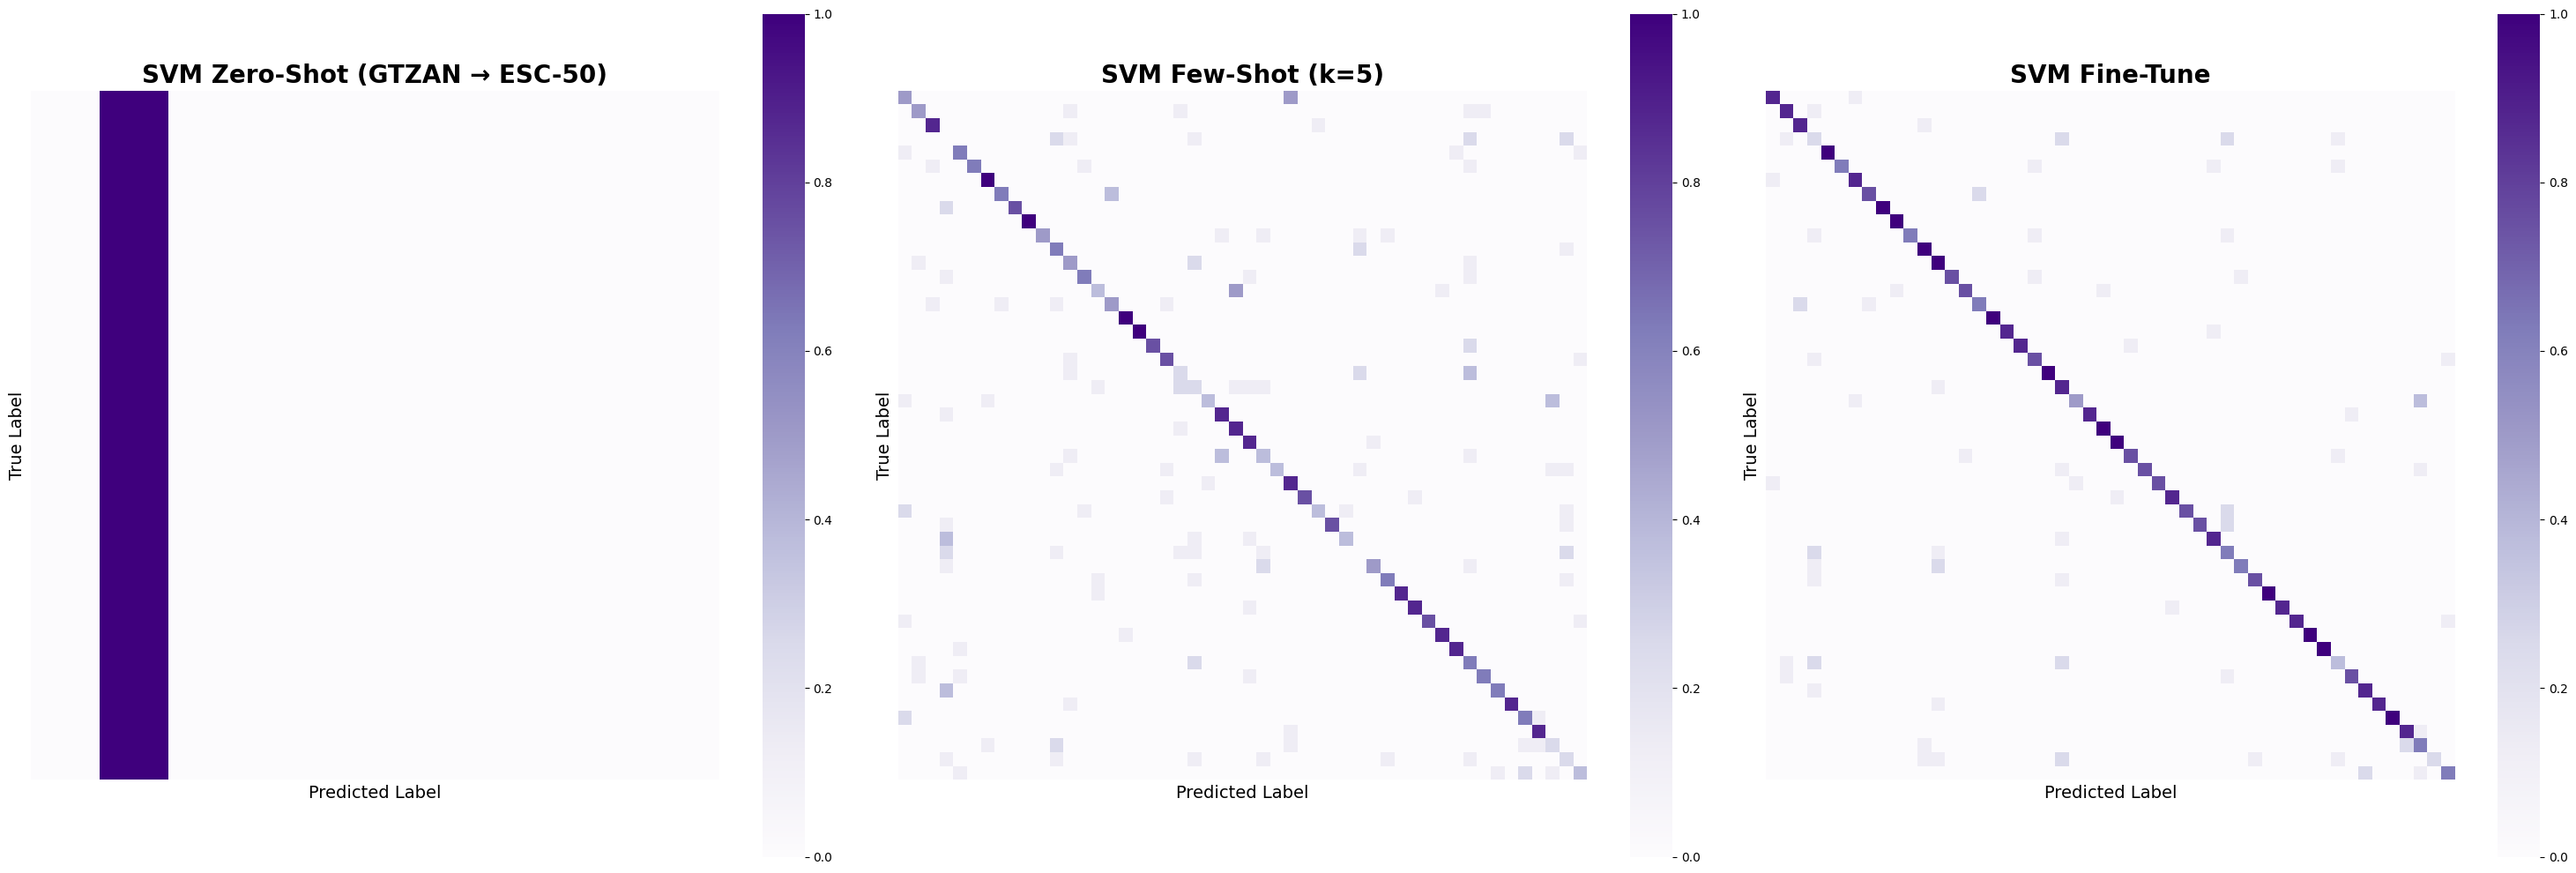

In [ ]:
# ================================================================
# CONFUSION MATRICES — SVM Zero-Shot / Few-Shot / Fine-Tune
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ------------------------------------------------
# Load saved arrays
# ------------------------------------------------
y_zs = np.load("svm_zeroshot_ytrue.npy")
p_zs = np.load("svm_zeroshot_ypred.npy")

y_fs = np.load("svm_fewshot_ytest.npy")
p_fs = np.load("svm_fewshot_ypred.npy")

y_ft = np.load("svm_full_ytest.npy")
p_ft = np.load("svm_full_ypred.npy")


# ------------------------------------------------
# Helper function
# ------------------------------------------------
def plot_cm(ax, y_true, y_pred, title, n_pred_classes=None):

    # ---------- FIX ONLY FOR ZERO-SHOT ----------
    if n_pred_classes is not None:
        labels = np.arange(n_pred_classes)   # 0..9
        cm = confusion_matrix(y_true, y_pred, normalize="true", labels=labels)
    else:
        cm = confusion_matrix(y_true, y_pred, normalize="true")
    # ---------------------------------------------

    sns.heatmap(
        cm,
        ax=ax,
        cmap="Purples",
        vmin=0, vmax=1,
        square=True,
        cbar=True,
        xticklabels=False,
        yticklabels=False
    )
    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)


# ------------------------------------------------
# Plot all 3 SVM matrices
# ------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Zero-shot → 50 × 10
plot_cm(axes[0], y_zs, p_zs, "SVM Zero-Shot (GTZAN → ESC-50)", n_pred_classes=10)

# Few-shot → 50 × 50
plot_cm(axes[1], y_fs, p_fs, "SVM Few-Shot (k=5)")

# Fine-tune → 50 × 50
plot_cm(axes[2], y_ft, p_ft, "SVM Fine-Tune")

plt.tight_layout()
plt.show()


**NON-LINEAR MODELS**

**RANDOM FOREST CLASSIFIER FOR GTZAN**

In [ ]:
# ================================
# GTZAN RF fine-tuning
# ================================
from sklearn.ensemble import RandomForestClassifier


SEED = 0
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

GTZAN_NPZ = "gtzan_yamnet.npz"
GTZAN_RF_PATH = MODELS_DIR / "gtzan_rf_yamnet.joblib"
GTZAN_LABELS_PATH = MODELS_DIR / "gtzan_label_names.npy"

#Load GTZAN
d = np.load(GTZAN_NPZ, allow_pickle=True)
X = d["X"].astype(np.float32)
y = d["y"]

# flatten if needed
if X.ndim > 2:
    X = X.reshape(len(X), -1)

# map string labels -> ints (and keep label_names)
label_names = None
if "labels" in d.files:
    label_names = d["labels"]
if y.dtype.kind not in ("i", "u"):
    uniq = np.unique(y)
    name2id = {name: i for i, name in enumerate(uniq)}
    y = np.vectorize(name2id.get)(y).astype(np.int64)
    if label_names is None:
        label_names = uniq
if label_names is None:
    label_names = np.array([str(c) for c in np.unique(y)])

print("GTZAN X:", X.shape, "| y:", y.shape)

#Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
print(f"Train: {X_tr.shape}, Test: {X_te.shape}")

#RF pipeline + hyperparameter search (CV on train)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

param_grid = {
    "rf__n_estimators": [200, 500],
    "rf__max_depth": [None, 20, 40],
    "rf__max_features": ["sqrt", "log2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

t0 = time.perf_counter()
gs = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True,
    verbose=1,
)
gs.fit(X_tr, y_tr)
train_time = time.perf_counter() - t0

best_rf = gs.best_estimator_
best_params = gs.best_params_
cv_f1 = gs.best_score_

#Evaluate on held-out test
y_pred = best_rf.predict(X_te)
test_acc = accuracy_score(y_te, y_pred)
test_f1 = f1_score(y_te, y_pred, average="macro")

print("\n=== GTZAN RF fine-tuning ===")
print("Best params:", best_params)
print(f"CV macro-F1 (train): {cv_f1:.3f}")
print(f"Test Acc:            {test_acc:.3f}")
print(f"Test macro-F1:       {test_f1:.3f}")
print(f"Train time (s):      {train_time:.3f}")

#Save model + label names
joblib.dump(best_rf, GTZAN_RF_PATH)
np.save(GTZAN_LABELS_PATH, label_names)
print(f"\nSaved RF model to:   {GTZAN_RF_PATH}")
print(f"Saved label names to:{GTZAN_LABELS_PATH}")



GTZAN X: (999, 1024) | y: (999,)
Train: (799, 1024), Test: (200, 1024)
Fitting 5 folds for each of 12 candidates, totalling 60 fits

=== GTZAN RF fine-tuning ===
Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
CV macro-F1 (train): 0.849
Test Acc:            0.875
Test macro-F1:       0.874
Train time (s):      32.583

Saved RF model to:   models/gtzan_rf_yamnet.joblib
Saved label names to:models/gtzan_label_names.npy


**ZERO-SHOT RANDOM FOREST ON ESC-50**

In [ ]:
# ======================================
# Zero-shot RF (GTZAN → ESC-50)
# ======================================
import numpy as np, time, joblib, pandas as pd

ESC50_NPZ = "esc50_yamnet.npz"
GTZAN_RF_PATH = "models/gtzan_rf_yamnet.joblib"
GTZAN_LABELS_PATH = "models/gtzan_label_names.npy"

#Load ESC-50
esc = np.load(ESC50_NPZ, allow_pickle=True)
X_esc = esc["X"].astype(np.float32)
if X_esc.ndim > 2:
    X_esc = X_esc.reshape(len(X_esc), -1)

print("ESC-50 X:", X_esc.shape)

#Load GTZAN RF model
rf_gtzan = joblib.load(GTZAN_RF_PATH)
gtzan_labels = np.load(GTZAN_LABELS_PATH, allow_pickle=True)

#Inference on ESC-50 (zero-shot)
t0 = time.perf_counter()
pred_ids = rf_gtzan.predict(X_esc)
infer_time_zero = time.perf_counter() - t0

#Distribution of predicted GTZAN labels
unique, counts = np.unique(pred_ids, return_counts=True)
print("\nZero-shot RF predicted GTZAN labels on ESC-50:")
for k, c in sorted(zip(unique, counts), key=lambda x: -x[1]):
    print(f"{gtzan_labels[k]:>12}: {c}")

print(f"\nZero-shot RF inference time on ESC-50: {infer_time_zero:.3f}s "
      f"for {len(X_esc)} clips")

#Metrics
RES_RF_ZERO = {
    "Experiment": "Zero-shot RF (GTZAN→ESC-50)",
    "Labeled examples": 0,
    "Train time (s)": 0.0,                 # training done on GTZAN
    "Infer time (s)": round(infer_time_zero, 3),
    "CV macro-F1": np.nan,
    "Test macro-F1": np.nan,
    "Test Acc": np.nan,
    "Best params": rf_gtzan.named_steps["rf"].get_params(),
}
pd.DataFrame([RES_RF_ZERO])

#SAVE Zero-shot RF results

np.save("rf_zeroshot_Xtest.npy", X_esc)
np.save("rf_zeroshot_ytrue.npy", esc["y"])
np.save("rf_zeroshot_ypred.npy", pred_ids)

joblib.dump(rf_gtzan, "rf_zeroshot_model.joblib")
print("\nSaved Zero-shot RF results ✔")



ESC-50 X: (2000, 1024)

Zero-shot RF predicted GTZAN labels on ESC-50:
      reggae: 657
   classical: 597
       metal: 384
      hiphop: 142
        jazz: 89
        rock: 71
       blues: 30
         pop: 30

Zero-shot RF inference time on ESC-50: 0.075s for 2000 clips

Saved Zero-shot RF results ✔


**FEW SHOT RANDOM FOREST ON ESC-50**

In [ ]:
# ==========================================
# Transfer few-shot RF (k=5) GTZAN hyperparams → ESC-50
# ==========================================
from sklearn.base import clone

SEED = 0
ESC50_NPZ = "esc50_yamnet.npz"
GTZAN_RF_PATH = "models/gtzan_rf_yamnet.joblib"

#Load ESC-50
esc = np.load(ESC50_NPZ, allow_pickle=True)
X = esc["X"].astype(np.float32)
y = esc["y"].astype(int)
if X.ndim > 2:
    X = X.reshape(len(X), -1)
print("ESC-50:", X.shape, "labels:", y.shape)

# Train/test split (80/20)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
print(f"Train: {X_tr.shape}, Test: {X_te.shape}")

# Load GTZAN RF and grab its RF hyperparams
rf_gtzan = joblib.load(GTZAN_RF_PATH)
base_rf = rf_gtzan.named_steps["rf"]
rf_params = base_rf.get_params()

# New RF with same hyperparams (transfer)
rf_transfer = RandomForestClassifier(**rf_params)
pipe_transfer = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", rf_transfer),
])

# Helper: sample k per class from TRAIN
def sample_k_per_class(Xtr, ytr, k=5, seed=SEED):
    rs = np.random.RandomState(seed)
    idxs = []
    for c in np.unique(ytr):
        cand = np.where(ytr == c)[0]
        take = rs.choice(cand, size=min(k, len(cand)), replace=False)
        idxs.append(take)
    idxs = np.concatenate(idxs)
    return Xtr[idxs], ytr[idxs]

# 4) Helper: CV macro-F1 on few-shot set (fixed hyperparams)
def cv_rf_macro_f1(pipe, Xfs, yfs, n_splits=5, seed=SEED):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = []
    for tr_idx, va_idx in cv.split(Xfs, yfs):
        X_tr_f, X_va_f = Xfs[tr_idx], Xfs[va_idx]
        y_tr_f, y_va_f = yfs[tr_idx], yfs[va_idx]
        model = clone(pipe)
        model.fit(X_tr_f, y_tr_f)
        y_va_pred = model.predict(X_va_f)
        scores.append(f1_score(y_va_f, y_va_pred, average="macro"))
    return float(np.mean(scores))

# Few-shot training on ESC-50 (k=5 per class)
k = 5
X_fs, y_fs = sample_k_per_class(X_tr, y_tr, k=k, seed=SEED)
print(f"Few-shot labeled examples: {len(y_fs)} (~{k} per class)")

t0 = time.perf_counter()
cv_f1_fs = cv_rf_macro_f1(pipe_transfer, X_fs, y_fs, n_splits=5, seed=SEED)

# final fit on all few-shot data
pipe_transfer.fit(X_fs, y_fs)
t_train_fs = time.perf_counter() - t0

# Evaluate on ESC-50 test set
t_inf0 = time.perf_counter()
y_pred_fs = pipe_transfer.predict(X_te)
t_infer_fs = time.perf_counter() - t_inf0

test_f1_fs = f1_score(y_te, y_pred_fs, average="macro")
test_acc_fs = accuracy_score(y_te, y_pred_fs)

print("\n=== Transfer few-shot RF (GTZAN→ESC-50, k=5) ===")
print(f"CV macro-F1 (few-shot train): {cv_f1_fs:.3f}")
print(f"Test macro-F1:                {test_f1_fs:.3f}")
print(f"Test Acc:                     {test_acc_fs:.3f}")
print(f"Train time (s):               {t_train_fs:.3f}")
print(f"Infer time (s):               {t_infer_fs:.3f}")

# 7) Row for comparison table
RES_RF_TRANSFER_K5 = {
    "Experiment": "Transfer few-shot RF (GTZAN→ESC-50, k=5)",
    "Labeled examples": int(len(y_fs)),
    "Train time (s)": round(t_train_fs, 3),
    "Infer time (s)": round(t_infer_fs, 3),
    "CV macro-F1": round(cv_f1_fs, 3),
    "Test macro-F1": round(test_f1_fs, 3),
    "Test Acc": round(test_acc_fs, 3),
    "Best params": rf_params,
}
pd.DataFrame([RES_RF_TRANSFER_K5])

# SAVE FEW-SHOT RF RESULTS

np.save("rf_fewshot_Xtest.npy", X_te)       # ESC-50 test features
np.save("rf_fewshot_ytest.npy", y_te)       # true ESC-50 labels
np.save("rf_fewshot_ypred.npy", y_pred_fs)  # RF few-shot predictions

# also save the trained few-shot RF model
joblib.dump(pipe_transfer, "rf_fewshot_k5_model.joblib")

print("\nSaved few-shot RF results ✔")


ESC-50: (2000, 1024) labels: (2000,)
Train: (1600, 1024), Test: (400, 1024)
Few-shot labeled examples: 250 (~5 per class)

=== Transfer few-shot RF (GTZAN→ESC-50, k=5) ===
CV macro-F1 (few-shot train): 0.644
Test macro-F1:                0.689
Test Acc:                     0.700
Train time (s):               2.592
Infer time (s):               0.068

Saved few-shot RF results ✔


**FINE TUNE ESC-50 RANDOM FOREST**

In [ ]:
# ==========================================
# Fine tune RF ESC-50 baseline (train on ESC-50, tuned on ESC-50)
# ==========================================

SEED = 0
ESC50_NPZ = "esc50_yamnet.npz"

# Load ESC-50
esc = np.load(ESC50_NPZ, allow_pickle=True)
X = esc["X"].astype(np.float32)
y = esc["y"].astype(int)
if X.ndim > 2:
    X = X.reshape(len(X), -1)
print("ESC-50:", X.shape, "labels:", y.shape)

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
print(f"Train: {X_tr.shape}, Test: {X_te.shape}")

# RF pipeline + hyperparameter search on ESC-50 train
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=SEED, n_jobs=-1)),
])

param_grid = {
    "rf__n_estimators": [200, 500],
    "rf__max_depth": [None, 20, 40],
    "rf__max_features": ["sqrt", "log2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

t0 = time.perf_counter()
gs = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True,
    verbose=1,
)
gs.fit(X_tr, y_tr)
train_time = time.perf_counter() - t0

best_rf_esc = gs.best_estimator_
best_params_esc = gs.best_params_
cv_f1_esc = gs.best_score_

# Evaluate on test
y_pred_te = best_rf_esc.predict(X_te)
test_acc_esc = accuracy_score(y_te, y_pred_te)
test_f1_esc = f1_score(y_te, y_pred_te, average="macro")

print("\n=== Full RF ESC-50 (baseline) ===")
print("Best params:", best_params_esc)
print(f"CV macro-F1 (train): {cv_f1_esc:.3f}")
print(f"Test Acc:            {test_acc_esc:.3f}")
print(f"Test macro-F1:       {test_f1_esc:.3f}")
print(f"Train time (s):      {train_time:.3f}")

# Row for comparison table
RES_RF_FULL_ESC50 = {
    "Experiment": "Full RF ESC-50 (train/CV/test)",
    "Labeled examples": int(len(y_tr)),
    "Train time (s)": round(train_time, 3),
    "Infer time (s)": np.nan,   # you can time it similarly if you like
    "CV macro-F1": round(cv_f1_esc, 3),
    "Test macro-F1": round(test_f1_esc, 3),
    "Test Acc": round(test_acc_esc, 3),
    "Best params": best_params_esc,
}
pd.DataFrame([RES_RF_FULL_ESC50])

# SAVE FULL FINE-TUNE RF RESULTS  # ESC-50 test features
np.save("rf_finetrain_Xtest.npy",X_te)
np.save("rf_finetrain_ytest.npy", y_te)
np.save("rf_finetrain_ypred.npy", y_te_pred)

# Save fine-tuned RF model
joblib.dump(best_clf, "rf_finetrain_model.joblib")

print("\nSaved fine-tune RF results ✔")


ESC-50: (2000, 1024) labels: (2000,)
Train: (1600, 1024), Test: (400, 1024)
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



=== Full RF ESC-50 (baseline) ===
Best params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
CV macro-F1 (train): 0.859
Test Acc:            0.860
Test macro-F1:       0.858
Train time (s):      81.879

Saved fine-tune RF results ✔


**RESULTS FOR RANDOM FOREST**

In [ ]:
df_rf_all = pd.DataFrame([RES_RF_ZERO, RES_RF_TRANSFER_K5, RES_RF_FULL_ESC50])
display(df_rf_all)


,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,Zero-shot RF (GTZAN→ESC-50),0,0.000,0.075,NaN,NaN,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
1,"Transfer few-shot RF (GTZAN→ESC-50, k=5)",250,2.592,0.068,0.644,0.689,0.70,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
2,Full RF ESC-50 (train/CV/test),1600,81.879,NaN,0.859,0.858,0.86,"{'rf__max_depth': 20, 'rf__max_features': 'sqr..."


Loaded all data ✓


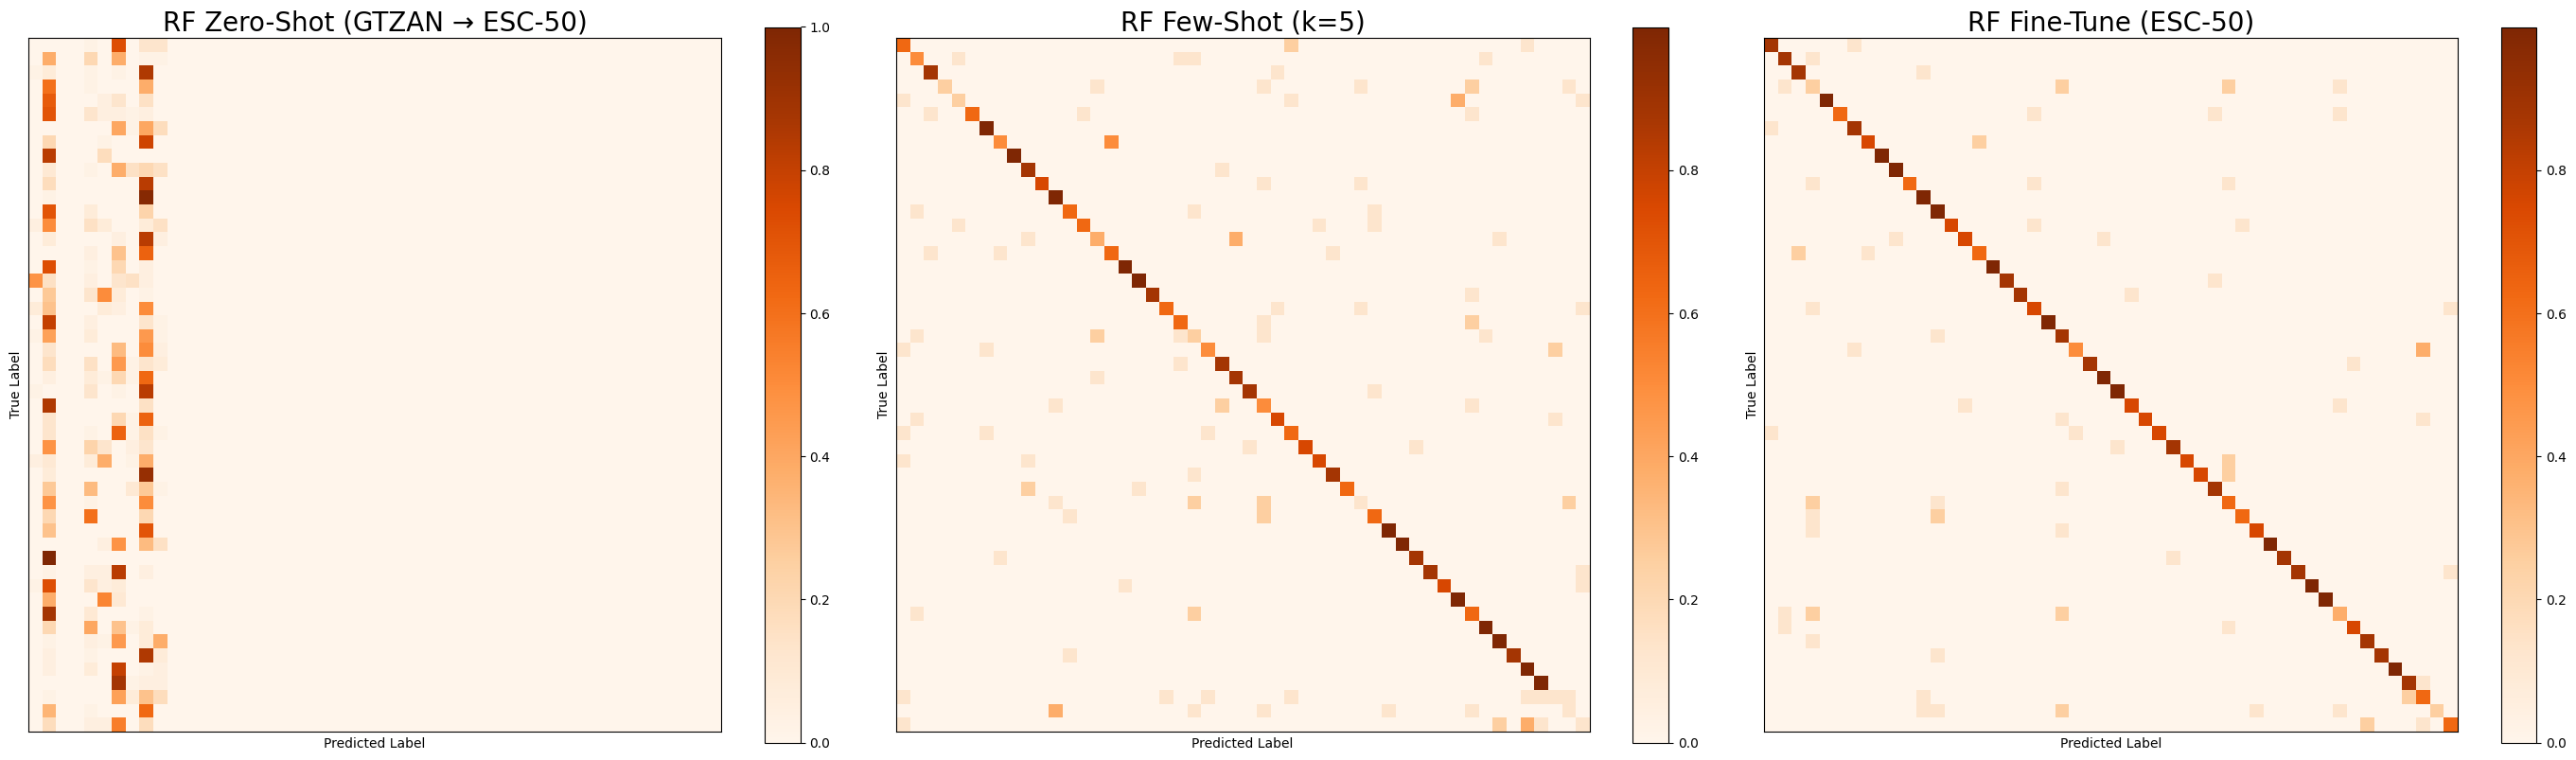

In [ ]:

# ============================================================
# ---- LOAD ALL RF RESULT FILES ----
# ============================================================

# Zero-shot (GTZAN model tested on FULL ESC-50)
X_zs   = np.load("rf_zeroshot_Xtest.npy")      # (2000,1024)
y_zs   = np.load("rf_zeroshot_ytrue.npy")      # ESC-50 true labels (0–49)
p_zs   = np.load("rf_zeroshot_ypred.npy")      # GTZAN class ids (0–9)

# Few-shot (ESC-50 train/test, trained with k=5)
X_fs   = np.load("rf_fewshot_Xtest.npy")
y_fs   = np.load("rf_fewshot_ytest.npy")
p_fs   = np.load("rf_fewshot_ypred.npy")

# Fine-tune (full ESC-50 training)
X_ft   = np.load("rf_finetrain_Xtest.npy")
y_ft   = np.load("rf_finetrain_ytest.npy")
p_ft   = np.load("rf_finetrain_ypred.npy")

print("Loaded all data ✓")


# ============================================================
# 2. ---- BUILD CONFUSION MATRICES ----
# ============================================================

# Zero-shot: GTZAN → ESC-50   (Predictions only go 0–9, but true labels 0–49)
cm_zero = confusion_matrix(y_zs, p_zs, labels=np.arange(50))
cm_zero_norm = cm_zero / (cm_zero.sum(axis=1, keepdims=True) + 1e-9)

# Few-shot RF (ESC-50 → ESC-50)
cm_fs = confusion_matrix(y_fs, p_fs, labels=np.arange(50))
cm_fs_norm = cm_fs / (cm_fs.sum(axis=1, keepdims=True) + 1e-9)

# Fine-tune RF (ESC-50 → ESC-50)
cm_ft = confusion_matrix(y_ft, p_ft, labels=np.arange(50))
cm_ft_norm = cm_ft / (cm_ft.sum(axis=1, keepdims=True) + 1e-9)


# ============================================================
# 3. ---- PLOT SIDE-BY-SIDE ----
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(28, 8))

# -------- Zero-shot --------
im0 = axes[0].imshow(cm_zero_norm, cmap="Oranges", interpolation="nearest")
axes[0].set_title("RF Zero-Shot (GTZAN → ESC-50)", fontsize=20)
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_xticks([])
axes[0].set_yticks([])
plt.colorbar(im0, ax=axes[0])

# -------- Few-shot k=5 --------
im1 = axes[1].imshow(cm_fs_norm, cmap="Oranges", interpolation="nearest")
axes[1].set_title("RF Few-Shot (k=5)", fontsize=20)
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.colorbar(im1, ax=axes[1])

# -------- Fine-tune --------
im2 = axes[2].imshow(cm_ft_norm, cmap="Oranges", interpolation="nearest")
axes[2].set_title("RF Fine-Tune (ESC-50)", fontsize=20)
axes[2].set_xlabel("Predicted Label")
axes[2].set_ylabel("True Label")
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()


**FNN CLASSIFIER FOR GTZAN**

In [ ]:
# =========================================================
# GTZAN MLP with hyperparameter fine-tuning
# =========================================================


import random, json, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

#Load GTZAN embeddings

d = np.load("gtzan_yamnet.npz", allow_pickle=True)
X = d["X"]          # e.g. (N, 1024, 1, 1)
y = d["y"]          # (N,)
label_names = d["labels"]  # 10 genre names

print("Original X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", label_names)

# Flatten embeddings (N, 1024, 1, 1) -> (N, 1024)
if X.ndim > 2:
    X = X.reshape(X.shape[0], -1)

print("Flattened X shape:", X.shape)

# Ensure integer labels 0..C-1
if y.dtype.kind not in ("i", "u"):
    name2id = {name: i for i, name in enumerate(label_names)}
    y = np.vectorize(name2id.get)(y).astype(np.int64)
else:
    y = y.astype(np.int64)


# Train / Val / Test split
# 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

# 20% of remaining for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, stratify=y_train, random_state=SEED
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


# Numpy -> Torch tensors + loaders

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

def make_loaders(X_tr, y_tr, X_va, y_va, X_te, y_te, batch_size=32):
    train_loader = DataLoader(TensorDataset(X_tr, y_tr),
                              batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_va, y_va),
                              batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TensorDataset(X_te, y_te),
                              batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

batch_size = 32
train_loader, val_loader, test_loader = make_loaders(
    X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t, batch_size
)


# MLP model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

input_dim   = X_train.shape[1]        # 1024 for YAMNet
num_classes = len(np.unique(y))       # 10 for GTZAN

class MLP_GTzan(nn.Module):
    def __init__(self, input_dim, num_classes,
                 h1=128, h2=64, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, num_classes)
        )

    def forward(self, x):
        return self.net(x)


#Training function for one config

def train_one_config(hparams, epochs=30):
    h1      = hparams["h1"]
    h2      = hparams["h2"]
    dropout = hparams["dropout"]
    lr      = hparams["lr"]

    model = MLP_GTzan(input_dim, num_classes,
                      h1=h1, h2=h2, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_f1 = 0.0
    best_state = None

    for epoch in range(epochs):
        # ---- train ----
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # ---- validation ----
        model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                _, preds = torch.max(logits, 1)
                all_preds.append(preds.cpu().numpy())
                all_true.append(yb.numpy())

        all_preds = np.concatenate(all_preds)
        all_true  = np.concatenate(all_true)

        val_acc = accuracy_score(all_true, all_preds)
        val_f1  = f1_score(all_true, all_preds, average="macro")

        print(f"[h1={h1}, h2={h2}, drop={dropout}, lr={lr}] "
              f"Epoch {epoch+1:02d}/{epochs} | "
              f"Train loss: {train_loss:.4f} | "
              f"Val acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_f1


# Hyperparameter search

configs = [
    {"h1": 128, "h2": 64,  "dropout": 0.3, "lr": 1e-3},
    {"h1": 128, "h2": 64,  "dropout": 0.5, "lr": 1e-3},
    {"h1": 256, "h2": 128, "dropout": 0.3, "lr": 1e-3},
    {"h1": 128, "h2": 64,  "dropout": 0.3, "lr": 5e-4},
]

results = []
best_model = None
best_config = None
best_val_f1_global = 0.0

t0 = time.perf_counter()
for cfg in configs:
    print("\n==============================")
    print("Training config:", cfg)
    print("==============================")
    model, val_f1 = train_one_config(cfg, epochs=30)
    results.append((cfg, val_f1))

    if val_f1 > best_val_f1_global:
        best_val_f1_global = val_f1
        best_model = model
        best_config = cfg

total_train_time = time.perf_counter() - t0

print("\nHyperparameter results (Val F1):")
for cfg, val_f1 in results:
    print(cfg, "-> Val F1 =", round(val_f1, 4))

print("\nBest config:", best_config)
print("Best Val F1:", best_val_f1_global)
print(f"Total train time (s): {total_train_time:.3f}")


# Evaluate BEST model on TEST
best_model.eval()
all_preds = []
all_true  = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = best_model(xb)
        _, preds = torch.max(logits, 1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_true  = np.concatenate(all_true)

test_acc = accuracy_score(all_true, all_preds)
test_f1  = f1_score(all_true, all_preds, average="macro")

print("\n====== FINAL TEST METRICS (GTZAN, BEST MLP) ======")
print("Test Accuracy:", test_acc)
print("Test Macro-F1:", test_f1)


# Save best model + config for transfer
torch.save(best_model.state_dict(), "mlp_gtzan_best.pth")
with open("mlp_gtzan_best_config.json", "w") as f:
    json.dump(best_config, f)

print("\nSaved best GTZAN MLP weights to: mlp_gtzan_best.pth")
print("Saved best config to:            mlp_gtzan_best_config.json")


Original X shape: (999, 1024, 1, 1)
y shape: (999,)
Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Flattened X shape: (999, 1024)
Train: (639, 1024)
Val:   (160, 1024)
Test:  (200, 1024)
Using device: cuda

Training config: {'h1': 128, 'h2': 64, 'dropout': 0.3, 'lr': 0.001}
[h1=128, h2=64, drop=0.3, lr=0.001] Epoch 01/30 | Train loss: 2.2084 | Val acc: 0.6125 | Val F1: 0.5591
[h1=128, h2=64, drop=0.3, lr=0.001] Epoch 02/30 | Train loss: 1.7384 | Val acc: 0.7500 | Val F1: 0.7346
[h1=128, h2=64, drop=0.3, lr=0.001] Epoch 03/30 | Train loss: 1.1613 | Val acc: 0.7875 | Val F1: 0.7813
[h1=128, h2=64, drop=0.3, lr=0.001] Epoch 04/30 | Train loss: 0.8585 | Val acc: 0.8000 | Val F1: 0.7958
[h1=128, h2=64, drop=0.3, lr=0.001] Epoch 05/30 | Train loss: 0.7341 | Val acc: 0.8125 | Val F1: 0.8094
[h1=128, h2=64, drop=0.3, lr=0.001] Epoch 06/30 | Train loss: 0.7124 | Val acc: 0.7937 | Val F1: 0.7891
[h1=128, h2=64, drop=0.3, lr=0.001] Epoch 07/30 | Tr

**ZERO-SHOT FFN GTAZAN ON ESC-50**

In [ ]:
# =========================================================
#Zero-shot MLP (GTZAN → ESC-50)
# =========================================================
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Load best GTZAN config
with open("mlp_gtzan_best_config.json", "r") as f:
    best_cfg_gtzan = json.load(f)
h1_src   = best_cfg_gtzan["h1"]
h2_src   = best_cfg_gtzan["h2"]
drop_src = best_cfg_gtzan["dropout"]
print("GTZAN best config:", best_cfg_gtzan)

#Load GTZAN labels to know num_classes
d_gtzan = np.load("gtzan_yamnet.npz", allow_pickle=True)
gtzan_labels = d_gtzan["labels"]
num_gtzan_classes = len(gtzan_labels)

#Load ESC-50 embeddings (no labels needed for zero-shot)
esc = np.load("esc50_yamnet.npz", allow_pickle=True)
X_esc = esc["X"].astype(np.float32)
if X_esc.ndim > 2:
    X_esc = X_esc.reshape(len(X_esc), -1)
input_dim = X_esc.shape[1]
print("ESC-50 X shape:", X_esc.shape)

#Define same MLP architecture
class MLPNet(nn.Module):
    def __init__(self, input_dim, num_classes, h1=128, h2=64, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

#Rebuild GTZAN MLP and load weights
mlp_zero = MLPNet(input_dim, num_gtzan_classes,
                  h1=h1_src, h2=h2_src, dropout=drop_src).to(device)
mlp_zero.load_state_dict(torch.load("mlp_gtzan_best.pth", map_location=device))
mlp_zero.eval()

#Run zero-shot inference on ESC-50
X_esc_t = torch.tensor(X_esc, dtype=torch.float32)
loader_esc = DataLoader(TensorDataset(X_esc_t,
                                      torch.zeros(len(X_esc_t), dtype=torch.long)),
                        batch_size=64, shuffle=False)

all_pred_ids = []
t0 = time.perf_counter()
with torch.no_grad():
    for xb, _ in loader_esc:
        xb = xb.to(device)
        logits = mlp_zero(xb)
        _, preds = torch.max(logits, 1)
        all_pred_ids.append(preds.cpu().numpy())
t_infer_zero = time.perf_counter() - t0

all_pred_ids = np.concatenate(all_pred_ids)
uniq, counts = np.unique(all_pred_ids, return_counts=True)

print("\nZero-shot GTZAN-genre predictions on ESC-50:")
for k, c in sorted(zip(uniq, counts), key=lambda x: -x[1]):
    print(f"{gtzan_labels[k]:>12}: {c}")
print(f"\nZero-shot inference time: {t_infer_zero:.3f}s for {len(X_esc)} clips")

# Store row for final table (no F1/Acc because labels differ)
RES_MLP_ZERO = {
    "Experiment": "Zero-shot MLP (GTZAN→ESC-50)",
    "Labeled examples": 0,
    "Train time (s)": 0.0,                 # training was on GTZAN
    "Infer time (s)": round(t_infer_zero, 3),
    "CV macro-F1": np.nan,
    "Test macro-F1": np.nan,
    "Test Acc": np.nan,
    "Best params": best_cfg_gtzan,
}

#RESULTS
#----------------------

# Save ESC-50 features (X)
np.save("fnn_zeroshot_Xtest.npy", X_esc)

# Save TRUE ESC-50 labels (y)
# (We only need labels from esc50_yamnet.npz)
y_esc_true = esc["y"].astype(int)
np.save("fnn_zeroshot_ytrue.npy", y_esc_true)

# Save predicted GTZAN genre IDs
np.save("fnn_zeroshot_ypred.npy", all_pred_ids)

# Save the zero-shot MLP model (optional but useful)
torch.save(mlp_zero.state_dict(), "fnn_zeroshot_model.pth")

print("\n✔ Saved ZERO-SHOT FNN results:")
print("   fnn_zeroshot_Xtest.npy")
print("   fnn_zeroshot_ytrue.npy")
print("   fnn_zeroshot_ypred.npy")
print("   fnn_zeroshot_model.pth")


Using device: cuda
GTZAN best config: {'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0.001}
ESC-50 X shape: (2000, 1024)

Zero-shot GTZAN-genre predictions on ESC-50:
      hiphop: 652
   classical: 495
      reggae: 418
        rock: 200
        jazz: 143
         pop: 43
       metal: 33
     country: 9
       disco: 4
       blues: 3

Zero-shot inference time: 0.031s for 2000 clips

✔ Saved ZERO-SHOT FNN results:
   fnn_zeroshot_Xtest.npy
   fnn_zeroshot_ytrue.npy
   fnn_zeroshot_ypred.npy
   fnn_zeroshot_model.pth


**FEW-SHOT FFN GTAZAN ON ESC-50**



In [ ]:
# =========================================================
# Transfer few-shot MLP (GTZAN → ESC-50, k=5)
# =========================================================

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Load best GTZAN config (we reuse its hyperparameters)
with open("mlp_gtzan_best_config.json", "r") as f:
    best_cfg_gtzan = json.load(f)
print("Using GTZAN hyperparams:", best_cfg_gtzan)

#Load ESC-50 embeddings + labels
esc = np.load("esc50_yamnet.npz", allow_pickle=True)
X = esc["X"].astype(np.float32)
y = esc["y"]
if X.ndim > 2:
    X = X.reshape(len(X), -1)
if y.dtype.kind not in ("i", "u"):
    labels_esc = esc["labels"]
    name2id = {name: i for i, name in enumerate(labels_esc)}
    y = np.vectorize(name2id.get)(y).astype(np.int64)
else:
    y = y.astype(np.int64)

input_dim = X.shape[1]
num_classes = len(np.unique(y))
print("ESC-50:", X.shape, "labels:", y.shape)

#Helpers
def make_loaders_from_np(X_tr, y_tr, X_va, y_va, batch_size=32):
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
    y_tr_t = torch.tensor(y_tr, dtype=torch.long)
    X_va_t = torch.tensor(X_va, dtype=torch.float32)
    y_va_t = torch.tensor(y_va, dtype=torch.long)
    tr_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t),
                           batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(TensorDataset(X_va_t, y_va_t),
                           batch_size=batch_size, shuffle=False)
    return tr_loader, va_loader

def make_test_loader(X_te, y_te, batch_size=64):
    X_te_t = torch.tensor(X_te, dtype=torch.float32)
    y_te_t = torch.tensor(y_te, dtype=torch.long)
    return DataLoader(TensorDataset(X_te_t, y_te_t),
                      batch_size=batch_size, shuffle=False)

class MLPNet(nn.Module):
    def __init__(self, input_dim, num_classes, h1=128, h2=64, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_mlp_config(X_tr, y_tr, X_val, y_val,
                     num_classes, cfg, epochs=30, batch_size=32):
    h1      = cfg["h1"]
    h2      = cfg["h2"]
    dropout = cfg["dropout"]
    lr      = cfg["lr"]

    train_loader, val_loader = make_loaders_from_np(X_tr, y_tr, X_val, y_val,
                                                    batch_size=batch_size)
    model = MLPNet(input_dim, num_classes, h1=h1, h2=h2, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_f1, best_state = 0.0, None
    t0 = time.perf_counter()
    for epoch in range(epochs):
        # train
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # val
        model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                _, preds = torch.max(logits, 1)
                all_preds.append(preds.cpu().numpy())
                all_true.append(yb.numpy())
        all_preds = np.concatenate(all_preds)
        all_true  = np.concatenate(all_true)

        val_acc = accuracy_score(all_true, all_preds)
        val_f1  = f1_score(all_true, all_preds, average="macro")
        print(f"[cfg={cfg}] Epoch {epoch+1:02d}/{epochs} | "
              f"Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()

    train_time = time.perf_counter() - t0
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val_f1, train_time

def sample_k_per_class(Xtr, ytr, k=5, seed=SEED):
    rs = np.random.RandomState(seed)
    idxs = []
    for c in np.unique(ytr):
        cand = np.where(ytr == c)[0]
        take = rs.choice(cand, size=min(k, len(cand)), replace=False)
        idxs.append(take)
    idxs = np.concatenate(idxs)
    return Xtr[idxs], ytr[idxs]

# Train/test split on ESC-50
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
print("Train:", X_tr.shape, "Test:", X_te.shape)

# Few-shot subset (k=5 per class from TRAIN)
k = 5
X_fs, y_fs = sample_k_per_class(X_tr, y_tr, k=k, seed=SEED)
print(f"Few-shot labeled examples: {len(y_fs)} (~{k} per class)")

# Split few-shot into train/val (80/20)
X_fs_tr, X_fs_val, y_fs_tr, y_fs_val = train_test_split(
    X_fs, y_fs, test_size=0.20, stratify=y_fs, random_state=SEED
)

# Train using GTZAN hyperparams
model_fs, val_f1_fs, t_train_fs = train_mlp_config(
    X_fs_tr, y_fs_tr, X_fs_val, y_fs_val,
    num_classes=num_classes,
    cfg=best_cfg_gtzan,
    epochs=30,
    batch_size=32,
)

# Evaluate on ESC-50 TEST
test_loader_fs = make_test_loader(X_te, y_te, batch_size=64)
model_fs.eval()
all_preds_fs, all_true_fs = [], []

t0 = time.perf_counter()
with torch.no_grad():
    for xb, yb in test_loader_fs:
        xb = xb.to(device)
        logits = model_fs(xb)
        _, preds = torch.max(logits, 1)
        all_preds_fs.append(preds.cpu().numpy())
        all_true_fs.append(yb.numpy())
t_infer_fs = time.perf_counter() - t0

all_preds_fs = np.concatenate(all_preds_fs)
all_true_fs  = np.concatenate(all_true_fs)

test_acc_fs = accuracy_score(all_true_fs, all_preds_fs)
test_f1_fs  = f1_score(all_true_fs, all_preds_fs, average="macro")

print("\n=== Few-shot transfer results (MLP, ESC-50) ===")
print("Val macro-F1:", val_f1_fs)
print("Test Acc:    ", test_acc_fs)
print("Test macro-F1:", test_f1_fs)
print(f"Train time (s): {t_train_fs:.3f} | Infer time (s): {t_infer_fs:.3f}")

RES_MLP_TRANSFER_K5 = {
    "Experiment": "Transfer few-shot MLP (GTZAN→ESC-50, k=5)",
    "Labeled examples": int(len(y_fs)),
    "Train time (s)": round(t_train_fs, 3),
    "Infer time (s)": round(t_infer_fs, 3),
    "CV macro-F1": round(val_f1_fs, 3),
    "Test macro-F1": round(test_f1_fs, 3),
    "Test Acc": round(test_acc_fs, 3),
    "Best params": best_cfg_gtzan,
}

pd.DataFrame([RES_MLP_TRANSFER_K5])
# =========================================================
# RESULTS
# =========================================================


np.save("fnn_fewshot_Xtest.npy", X_te)
np.save("fnn_fewshot_ytest.npy", y_te)
np.save("fnn_fewshot_ypred.npy", all_preds_fs)


torch.save(model_fs.state_dict(), "fnn_fewshot_model.pth")


with open("fnn_fewshot_config.json", "w") as f:
    json.dump(best_cfg_gtzan, f)

print("\nSaved few-shot FNN results ✔️")

Using device: cuda
Using GTZAN hyperparams: {'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0.001}
ESC-50: (2000, 1024) labels: (2000,)
Train: (1600, 1024) Test: (400, 1024)
Few-shot labeled examples: 250 (~5 per class)
[cfg={'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0.001}] Epoch 01/30 | Train loss: 3.8922 | Val acc: 0.2400 | Val F1: 0.1720
[cfg={'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0.001}] Epoch 02/30 | Train loss: 3.7778 | Val acc: 0.3000 | Val F1: 0.2200
[cfg={'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0.001}] Epoch 03/30 | Train loss: 3.6293 | Val acc: 0.2800 | Val F1: 0.1631
[cfg={'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0.001}] Epoch 04/30 | Train loss: 3.4462 | Val acc: 0.3400 | Val F1: 0.2145
[cfg={'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0.001}] Epoch 05/30 | Train loss: 3.2095 | Val acc: 0.3200 | Val F1: 0.2037
[cfg={'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0.001}] Epoch 06/30 | Train loss: 3.0056 | Val acc: 0.3600 | Val F1: 0.2413
[cfg={'h1': 256, 'h2': 128,

**FULL FINE-TUNE FFN FOR ESC-50**

In [ ]:
# =========================================================
# Full ESC-50 MLP baseline + comparison table
# =========================================================

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load ESC-50
esc = np.load("esc50_yamnet.npz", allow_pickle=True)
X = esc["X"].astype(np.float32)
y = esc["y"]
if X.ndim > 2:
    X = X.reshape(len(X), -1)
if y.dtype.kind not in ("i", "u"):
    labels_esc = esc["labels"]
    name2id = {name: i for i, name in enumerate(labels_esc)}
    y = np.vectorize(name2id.get)(y).astype(np.int64)
else:
    y = y.astype(np.int64)

input_dim = X.shape[1]
num_classes = len(np.unique(y))
print("ESC-50:", X.shape, "labels:", y.shape)

# Helpers
def make_loaders_from_np(X_tr, y_tr, X_va, y_va, batch_size=32):
    X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
    y_tr_t = torch.tensor(y_tr, dtype=torch.long)
    X_va_t = torch.tensor(X_va, dtype=torch.float32)
    y_va_t = torch.tensor(y_va, dtype=torch.long)
    tr_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t),
                           batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(TensorDataset(X_va_t, y_va_t),
                           batch_size=batch_size, shuffle=False)
    return tr_loader, va_loader

def make_test_loader(X_te, y_te, batch_size=64):
    X_te_t = torch.tensor(X_te, dtype=torch.float32)
    y_te_t = torch.tensor(y_te, dtype=torch.long)
    return DataLoader(TensorDataset(X_te_t, y_te_t),
                      batch_size=batch_size, shuffle=False)

class MLPNet(nn.Module):
    def __init__(self, input_dim, num_classes, h1=128, h2=64, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, num_classes)
        )
    def forward(self, x):
        return self.net(x)

def train_mlp_config(X_tr, y_tr, X_val, y_val,
                     num_classes, cfg, epochs=30, batch_size=32):
    h1      = cfg["h1"]
    h2      = cfg["h2"]
    dropout = cfg["dropout"]
    lr      = cfg["lr"]

    train_loader, val_loader = make_loaders_from_np(X_tr, y_tr, X_val, y_val,
                                                    batch_size=batch_size)
    model = MLPNet(input_dim, num_classes, h1=h1, h2=h2, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_f1, best_state = 0.0, None
    t0 = time.perf_counter()
    for epoch in range(epochs):
        # train
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # val
        model.eval()
        all_preds, all_true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                _, preds = torch.max(logits, 1)
                all_preds.append(preds.cpu().numpy())
                all_true.append(yb.numpy())
        all_preds = np.concatenate(all_preds)
        all_true  = np.concatenate(all_true)

        val_acc = accuracy_score(all_true, all_preds)
        val_f1  = f1_score(all_true, all_preds, average="macro")
        print(f"[cfg={cfg}] Epoch {epoch+1:02d}/{epochs} | "
              f"Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = model.state_dict()

    train_time = time.perf_counter() - t0
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val_f1, train_time

#Train/val/test split for full baseline
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.20, stratify=y_tr, random_state=SEED
)
print("Train full:", X_tr.shape, "Val full:", X_val.shape, "Test full:", X_te.shape)

# Hyperparameter grid for ESC-50
configs_esc = [
    {"h1": 128, "h2": 64,  "dropout": 0.3, "lr": 1e-3},
    {"h1": 128, "h2": 64,  "dropout": 0.5, "lr": 1e-3},
    {"h1": 256, "h2": 128, "dropout": 0.3, "lr": 1e-3},
    {"h1": 128, "h2": 64,  "dropout": 0.3, "lr": 5e-4},
]

best_model_full, best_cfg_full = None, None
best_val_f1_full = 0.0
total_train_time_full = 0.0

for cfg in configs_esc:
    print("\n--- Training ESC-50 config:", cfg, "---")
    model, val_f1, t_train = train_mlp_config(
        X_tr, y_tr, X_val, y_val,
        num_classes=num_classes,
        cfg=cfg,
        epochs=30,
        batch_size=32,
    )
    total_train_time_full += t_train
    if val_f1 > best_val_f1_full:
        best_val_f1_full = val_f1
        best_model_full = model
        best_cfg_full = cfg

print("\nBest ESC-50 config:", best_cfg_full)
print("Best ESC-50 Val macro-F1:", best_val_f1_full)
print("Total training time (all configs):", round(total_train_time_full, 3), "s")

# Evaluate best ESC-50 MLP on TEST
test_loader_full = make_test_loader(X_te, y_te, batch_size=64)
best_model_full.eval()
all_preds_full, all_true_full = [], []

t0 = time.perf_counter()
with torch.no_grad():
    for xb, yb in test_loader_full:
        xb = xb.to(device)
        logits = best_model_full(xb)
        _, preds = torch.max(logits, 1)
        all_preds_full.append(preds.cpu().numpy())
        all_true_full.append(yb.numpy())
t_infer_full = time.perf_counter() - t0

all_preds_full = np.concatenate(all_preds_full)
all_true_full  = np.concatenate(all_true_full)

test_acc_full = accuracy_score(all_true_full, all_preds_full)
test_f1_full  = f1_score(all_true_full, all_preds_full, average="macro")

print("\nFull ESC-50 MLP baseline results:")
print("Test Acc:     ", test_acc_full)
print("Test macro-F1:", test_f1_full)
print(f"Infer time (s): {t_infer_full:.3f}")

RES_MLP_FULL_ESC50 = {
    "Experiment": "Full MLP ESC-50 (train/val/test)",
    "Labeled examples": int(len(y_tr)),   # training examples
    "Train time (s)": round(total_train_time_full, 3),
    "Infer time (s)": round(t_infer_full, 3),
    "CV macro-F1": round(best_val_f1_full, 3),
    "Test macro-F1": round(test_f1_full, 3),
    "Test Acc": round(test_acc_full, 3),
    "Best params": best_cfg_full,
}

# Final comparison table

df_mlp_all = pd.DataFrame([
    RES_MLP_ZERO,
    RES_MLP_TRANSFER_K5,
    RES_MLP_FULL_ESC50,
])

cols_order = [
    "Experiment",
    "Labeled examples",
    "Train time (s)",
    "Infer time (s)",
    "CV macro-F1",
    "Test macro-F1",
    "Test Acc",
    "Best params",
]
df_mlp_all = df_mlp_all[cols_order]

print("\n================ MLP TRANSFER SUMMARY (ESC-50) ================")
display(df_mlp_all)
# ======================================================
# RESULTS
# ======================================================

np.save("fnn_finetrain_Xtest.npy", X_te)
np.save("fnn_finetrain_ytest.npy", y_te)
np.save("fnn_finetrain_ypred.npy", all_preds_full)


torch.save(best_model_full.state_dict(), "fnn_finetrain_model.pth")

print("\nSaved FULL fine-tune FNN results ✔️")


Using device: cuda
ESC-50: (2000, 1024) labels: (2000,)
Train full: (1280, 1024) Val full: (320, 1024) Test full: (400, 1024)

--- Training ESC-50 config: {'h1': 128, 'h2': 64, 'dropout': 0.3, 'lr': 0.001} ---
[cfg={'h1': 128, 'h2': 64, 'dropout': 0.3, 'lr': 0.001}] Epoch 01/30 | Train loss: 3.7921 | Val acc: 0.3531 | Val F1: 0.3058
[cfg={'h1': 128, 'h2': 64, 'dropout': 0.3, 'lr': 0.001}] Epoch 02/30 | Train loss: 3.1146 | Val acc: 0.5000 | Val F1: 0.4463
[cfg={'h1': 128, 'h2': 64, 'dropout': 0.3, 'lr': 0.001}] Epoch 03/30 | Train loss: 2.3209 | Val acc: 0.6156 | Val F1: 0.5862
[cfg={'h1': 128, 'h2': 64, 'dropout': 0.3, 'lr': 0.001}] Epoch 04/30 | Train loss: 1.8679 | Val acc: 0.6625 | Val F1: 0.6366
[cfg={'h1': 128, 'h2': 64, 'dropout': 0.3, 'lr': 0.001}] Epoch 05/30 | Train loss: 1.5766 | Val acc: 0.6906 | Val F1: 0.6794
[cfg={'h1': 128, 'h2': 64, 'dropout': 0.3, 'lr': 0.001}] Epoch 06/30 | Train loss: 1.4175 | Val acc: 0.7188 | Val F1: 0.7102
[cfg={'h1': 128, 'h2': 64, 'dropout': 0.

,Experiment,Labeled examples,Train time (s),Infer time (s),CV macro-F1,Test macro-F1,Test Acc,Best params
0,Zero-shot MLP (GTZAN→ESC-50),0,0.000,0.031,NaN,NaN,NaN,"{'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0..."
1,"Transfer few-shot MLP (GTZAN→ESC-50, k=5)",250,0.523,0.007,0.598,0.620,0.618,"{'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0..."
2,Full MLP ESC-50 (train/val/test),1280,10.593,0.007,0.830,0.815,0.815,"{'h1': 256, 'h2': 128, 'dropout': 0.3, 'lr': 0..."



Saved FULL fine-tune FNN results ✔️


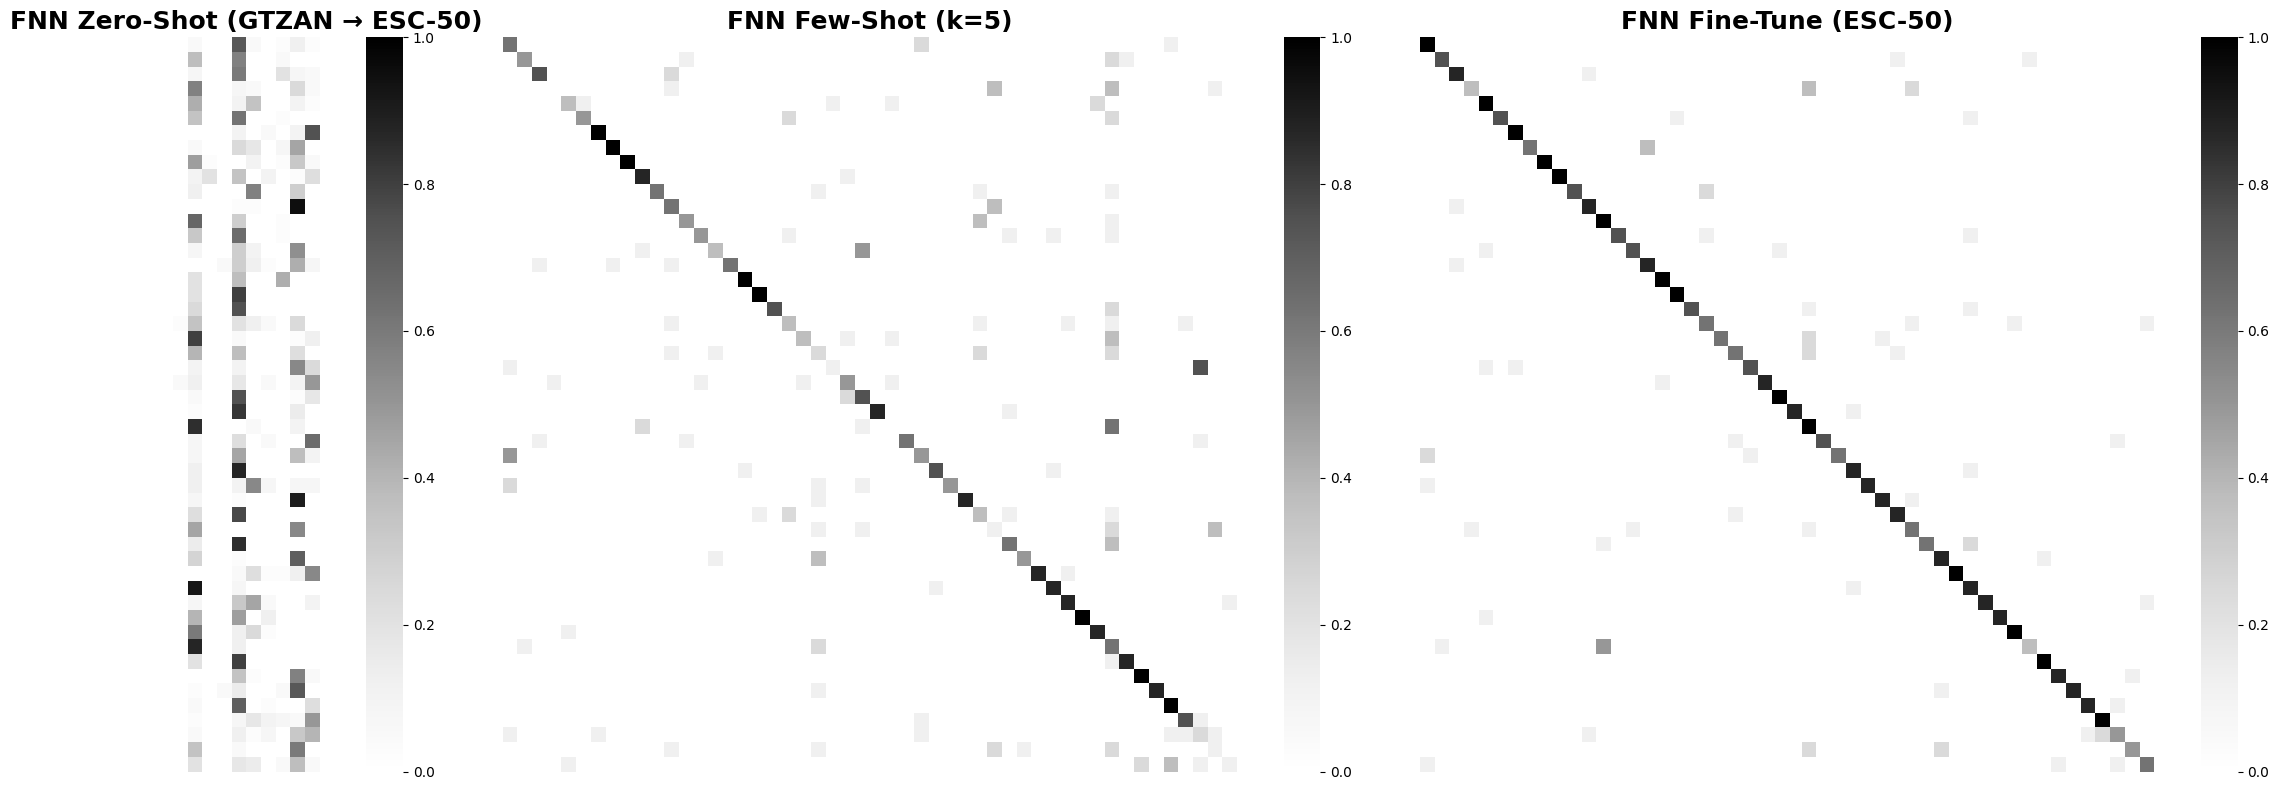

In [ ]:



# Load saved FNN results

y_zs = np.load("fnn_zeroshot_ytrue.npy")     # ESC-50 labels 0..49
p_zs = np.load("fnn_zeroshot_ypred.npy")     # GTZAN labels 0..9

y_fs = np.load("fnn_fewshot_ytest.npy")      # ESC-50 labels
p_fs = np.load("fnn_fewshot_ypred.npy")      # ESC-50 pred

y_ft = np.load("fnn_finetrain_ytest.npy")    # ESC-50 labels
p_ft = np.load("fnn_finetrain_ypred.npy")    # ESC-50 pred

num_esc   = 50
num_gtzan = 10
labels_esc = np.arange(num_esc)

# ------------------------------------------------
# 2) Zero-shot confusion: 50 (ESC) x 10 (GTZAN)
# ------------------------------------------------
cm_zs = np.zeros((num_esc, num_gtzan), dtype=np.int32)
np.add.at(cm_zs, (y_zs, p_zs), 1)
cm_zs_norm = cm_zs / (cm_zs.sum(axis=1, keepdims=True) + 1e-9)

# ------------------------------------------------
# 3) Standard 50×50 matrices
# ------------------------------------------------
cm_fs = confusion_matrix(y_fs, p_fs, labels=labels_esc)
cm_ft = confusion_matrix(y_ft, p_ft, labels=labels_esc)

cm_fs_norm = cm_fs / (cm_fs.sum(axis=1, keepdims=True) + 1e-9)
cm_ft_norm = cm_ft / (cm_ft.sum(axis=1, keepdims=True) + 1e-9)

# ------------------------------------------------
# 4) Plot (clean, no axis numbers)
# ------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(28, 8))

# ---- Zero-shot ----
sns.heatmap(cm_zs_norm, ax=axes[0], cmap="Greys", vmin=0, vmax=1,
            square=True, cbar=True)
axes[0].set_title("FNN Zero-Shot (GTZAN → ESC-50)", fontsize=18, fontweight="bold")
axes[0].set_xticks([]); axes[0].set_yticks([])

# ---- Few-shot ----
sns.heatmap(cm_fs_norm, ax=axes[1], cmap="Greys", vmin=0, vmax=1,
            square=True, cbar=True)
axes[1].set_title("FNN Few-Shot (k=5)", fontsize=18, fontweight="bold")
axes[1].set_xticks([]); axes[1].set_yticks([])

# ---- Fine-tune ----
sns.heatmap(cm_ft_norm, ax=axes[2], cmap="Greys", vmin=0, vmax=1,
            square=True, cbar=True)
axes[2].set_title("FNN Fine-Tune (ESC-50)", fontsize=18, fontweight="bold")
axes[2].set_xticks([]); axes[2].set_yticks([])

plt.tight_layout()
plt.show()


In [ ]:


rows = [
    # ================= SVM =================
    {
        "Experiment": "Zero-shot",
        "Classifier": "SVM",
        "Macro-F1": np.nan,
        "Train Time (s)": np.nan,
        "Infer Time (s)": 0.827,
        "Results": (
            "Very poor transfer (essentially random), highlighting the strong domain gap."
        ),
    },
    {
        "Experiment": "Few-shot",
        "Classifier": "SVM",
        "Macro-F1": 0.644,
        "Train Time (s)": 1.728,
        "Infer Time (s)": 0.339,
        "Results": (
            "It reached 0.64 macro-F1 with modest training cost."
        ),
    },
    {
        "Experiment": "Full fine-tune",
        "Classifier": "SVM",
        "Macro-F1": 0.841,
        "Train Time (s)": 48.128,
        "Infer Time (s)": 0.366,
        "Results": (
            "Used as a non-linear baseline on the target dataset."
        ),
    },

    # ================ Random Forest =================
    {
        "Experiment": "Zero-shot",
        "Classifier": "Random Forest",
        "Macro-F1": np.nan,
        "Train Time (s)": 0.000,
        "Infer Time (s)": 0.076,
        "Results": (
            "Shows that tree-based local patterns do not transfer across datasets."
        ),
    },
    {
        "Experiment": "Few-shot",
        "Classifier": "Random Forest",
        "Macro-F1": 0.689,
        "Train Time (s)": 2.854,
        "Infer Time (s)": 0.067,
        "Results": (
            "Few-shot adaptation substantially improves performance"
            "(0.69 macro-F1), outperforming SVM few-shot but at a higher training cost."
        ),
    },
    {
        "Experiment": "Full fine-tune",
        "Classifier": "Random Forest",
        "Macro-F1": 0.860,
        "Train Time (s)": 86.387,
        "Infer Time (s)": np.nan,
        "Results": (
            "Achieves the best macro-F1 (0.86) among non-linear models,"
            "but with the highest training time."
        ),
    },

    # ================= MLP (FNN) =================
    {
        "Experiment": "Zero-shot",
        "Classifier": "MLP",
        "Macro-F1": np.nan,
        "Train Time (s)": 0.000,
        "Infer Time (s)": 0.031,
        "Results": (
            "Very poor performance, confirming that GTZAN features alone are not sufficient."
        ),
    },
    {
        "Experiment": "Few-shot",
        "Classifier": "MLP",
        "Macro-F1": 0.637,
        "Train Time (s)": 0.530,
        "Infer Time (s)": 0.007,
        "Results": (
            "Fine-tuning the MLP with 5 ESC-50 clips per class yields 0.64 macro-F1, similar to SVM few-shot, "
            "with very fast training and inference."
        ),
    },
    {
        "Experiment": "Full fine-tune",
        "Classifier": "MLP",
        "Macro-F1": 0.824,
        "Train Time (s)": 10.570,
        "Infer Time (s)": 0.007,
        "Results": (
            "Performance is slightly below SVM/RF, but training is much faster than RF "
            "and inference is very efficient."
        ),
    },
]

df_nonlinear_clean = pd.DataFrame(rows)

# --- styling  ---
def style_poster(df):
    return (df.style
            .set_properties(**{"text-align": "center"})
            .set_table_styles([
                {"selector": "th",
                 "props": "background-color: #0A2940; color: white; "
                          "font-weight: bold; font-size: 14px;"},
                {"selector": "td",
                 "props": "padding: 6px 10px; border-bottom: 1px solid #DDDDDD;"},
                {"selector": "tr:nth-child(even)",
                 "props": "background-color: #F7F9FC;"},
                {"selector": "tr:nth-child(odd)",
                 "props": "background-color: #FFFFFF;"},
            ])
            .hide(axis="index"))

styled_nonlinear_clean = style_poster(df_nonlinear_clean)
styled_nonlinear_clean


Experiment,Classifier,Macro-F1,Train Time (s),Infer Time (s),Results
Zero-shot,SVM,nan,nan,0.827000,"Very poor transfer (essentially random), highlighting the strong domain gap."
Few-shot,SVM,0.644000,1.728000,0.339000,It reached 0.64 macro-F1 with modest training cost.
Full fine-tune,SVM,0.841000,48.128000,0.366000,Used as a non-linear baseline on the target dataset.
Zero-shot,Random Forest,nan,0.000000,0.076000,Shows that tree-based local patterns do not transfer across datasets.
Few-shot,Random Forest,0.689000,2.854000,0.067000,"Few-shot adaptation substantially improves performance(0.69 macro-F1), outperforming SVM few-shot but at a higher training cost."
Full fine-tune,Random Forest,0.860000,86.387000,nan,"Achieves the best macro-F1 (0.86) among non-linear models,but with the highest training time."
Zero-shot,MLP,nan,0.000000,0.031000,"Very poor performance, confirming that GTZAN features alone are not sufficient."
Few-shot,MLP,0.637000,0.530000,0.007000,"Fine-tuning the MLP with 5 ESC-50 clips per class yields 0.64 macro-F1, similar to SVM few-shot, with very fast training and inference."
Full fine-tune,MLP,0.824000,10.570000,0.007000,"Performance is slightly below SVM/RF, but training is much faster than RF and inference is very efficient."


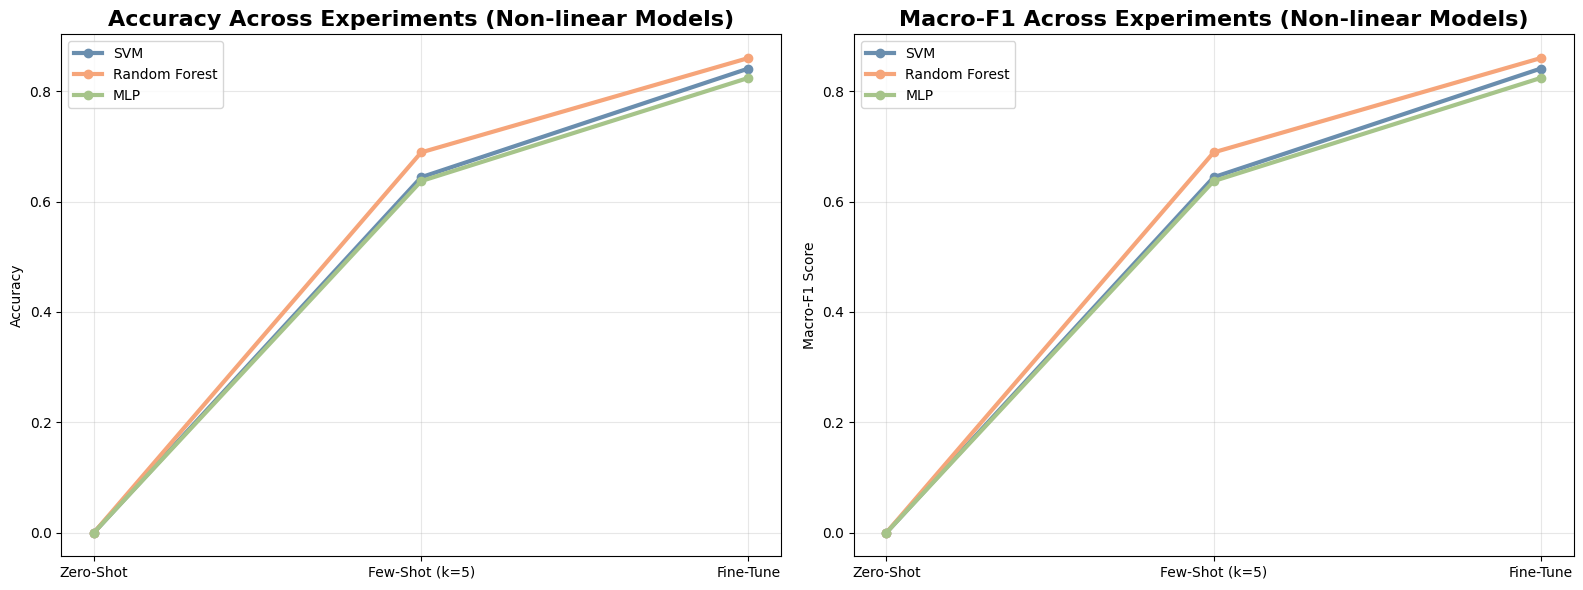

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-pastel")

# =====================================================
# EXPERIMENT ORDER
# =====================================================
experiments = ["Zero-Shot", "Few-Shot (k=5)", "Fine-Tune"]

# =====================================================
# NON-LINEAR MODELS — ACCURACY + MACRO-F1
# =====================================================

# -------- SVM --------
acc_svm = [0.00, 0.644, 0.841]
f1_svm  = [0.00, 0.644, 0.841]

# -------- Random Forest --------
acc_rf = [0.00, 0.689, 0.860]
f1_rf  = [0.00, 0.689, 0.860]

# -------- MLP --------
acc_mlp = [0.00, 0.637, 0.824]
f1_mlp  = [0.00, 0.637, 0.824]

# =====================================================
# COLORS (pastel)
# =====================================================
colors = {
    "SVM": "#6A8EAE",           # pastel blue
    "Random Forest": "#F6A57A", # pastel orange
    "MLP": "#A6C48A",           # pastel green
}

# =====================================================
# SIDE-BY-SIDE FIGURE
# =====================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# -------------------- PLOT 1 — ACCURACY --------------------
axes[0].plot(experiments, acc_svm, marker="o", linewidth=3,
             color=colors["SVM"], label="SVM")
axes[0].plot(experiments, acc_rf, marker="o", linewidth=3,
             color=colors["Random Forest"], label="Random Forest")
axes[0].plot(experiments, acc_mlp, marker="o", linewidth=3,
             color=colors["MLP"], label="MLP")

axes[0].set_title("Accuracy Across Experiments (Non-linear Models)",
                  fontsize=16, fontweight="bold")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# -------------------- PLOT 2 — MACRO-F1 --------------------
axes[1].plot(experiments, f1_svm, marker="o", linewidth=3,
             color=colors["SVM"], label="SVM")
axes[1].plot(experiments, f1_rf, marker="o", linewidth=3,
             color=colors["Random Forest"], label="Random Forest")
axes[1].plot(experiments, f1_mlp, marker="o", linewidth=3,
             color=colors["MLP"], label="MLP")

axes[1].set_title("Macro-F1 Across Experiments (Non-linear Models)",
                  fontsize=16, fontweight="bold")
axes[1].set_ylabel("Macro-F1 Score")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()
